In [1]:
# 安裝套件
import pandas as pd
import numpy as np
import pickle
import copy
import timeit
import warnings
warnings.filterwarnings("ignore")

from matplotlib import cm
from pandas import ExcelWriter
from functools import reduce
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x:'%.3f' % x)
np.set_printoptions(suppress=True) # 不要顯示科學記號

import seaborn as sns
import matplotlib.pyplot as plp
%matplotlib inline
from sklearn.metrics import mean_absolute_error
from sklearn import datasets, metrics
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
#安裝在畫圖時中文顯示的字體
from matplotlib.font_manager import fontManager
# 如果下載字體失敗, 再重新下載一次就可以了
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

--2023-06-16 12:12:54--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.251.107.113, 142.251.107.139, 142.251.107.101, ...
Connecting to drive.google.com (drive.google.com)|142.251.107.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/s9vv6r33jrte4u5edbll2fragtk6snbf/1686917550000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=b854d37f-5281-460e-98f9-f6bd24fabdf6 [following]
--2023-06-16 12:12:55--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/s9vv6r33jrte4u5edbll2fragtk6snbf/1686917550000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=b854d37f-5281-460e-98f9-f6bd24fabdf6
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 173.194.215.132, 2607:f8b0:400c:c0c::84
Connecting to d

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
asset = pd.read_excel('/content/drive/MyDrive/2011上市上櫃.xlsx', sheet_name='BS')
income = pd.read_excel('/content/drive/MyDrive/2011上市上櫃.xlsx', sheet_name='IS')
cash = pd.read_excel('/content/drive/MyDrive/2011上市上櫃.xlsx', sheet_name='CF')
company_industry = pd.read_excel('/content/drive/MyDrive/公司_產業_final.xlsx')
eps_df = pd.read_excel('/content/drive/MyDrive/EPS_調整diluted.xlsx')

In [5]:
asset

,公司,年月,現金及約當現金,透過損益按公允價值衡量之金融資產－流動,透過其他綜合損益按公允價值衡量之金融資產－流動,按攤銷後成本衡量之金融資產－流動,避險之金融資產－流動,合約資產－流動,應收帳款及票據,其他應收款,資金貸予他人－流動,存貨,待出售非流動資產,當期所得稅資產－流動,流動資產,透過損益按公允價值衡量之金融資產－非流動,透過其他綜合損益按公允價值衡量之金融資產－非流動,按攤銷後成本衡量之金融資產－非流動,避險之金融資產－非流動,合約資產－非流動,採權益法之長期股權投資,預付投資款,不動產廠房及設備,商譽及無形資產合計,遞延所得稅資產,遞延資產合計,使用權資產,投資性不動產淨額,其他非流動資產,非流動資產,資產總額,短期借款,應付商業本票∕承兌匯票,透過損益按公允價值衡量之金融負債－流動,避險之金融負債－流動,按攤銷後成本衡量之金融負債－流動,合約負債－流動,應付帳款及票據,其他應付款,當期所得稅負債,負債準備－流動,與待出售非流動資產直接相關之負債,租賃負債─流動,一年內到期長期負債,特別股負債－流動,流動負債,透過損益按公允價值衡量之金融負債－非流動,避險之金融負債－非流動,按攤銷後成本衡量之金融負債－非流動,合約負債－非流動,特別股負債－非流動,應付公司債－非流動,銀行借款－非流動,其他長期借款－非流動,租賃負債－非流動,負債準備－非流動,遞延貸項,應計退休金負債,遞延所得稅,非流動負債,負債總額,普通股股本,特別股股本,預收股款,待分配股票股利,換股權利證書,股本,資本公積合計,法定盈餘公積,特別盈餘公積,未分配盈餘,保留盈餘,其他權益,庫藏股票帳面值,母公司股東權益合計,共同控制下前手權益,合併前非屬共同控制股權,非控制權益,股東權益總額,負債及股東權益總額
0,1101 台泥,2011-12-30,22140268000.000,3152664000.000,13721102000.000,0.000,0.000,0.000,18074170000.000,49576000.000,1267612000.000,10598551000.000,1928978000.000,0.000,79269224000.000,1472569000.000,3127674000.000,0.000,0.000,NaN,9650998000.000,0.000,146486489000.000,13671350000.000,0.000,1750331000.000,NaN,64351000.000,6466305000.000,182625716000.000,261894940000,18891513000.000,4458344000.000,0.000,0.000,NaN,1429426000.000,8694590000.000,3423719000.000,1294394000.000,0.000,1434319000.000,NaN,17439820000.000,0.000,62253658000.000,0.000,68824000.000,NaN,NaN,0.000,3500000000.000,58988270000.000,109327000.000,NaN,0.000,0.000,271366000.000,7064013000.000,70320933000.000,132574591000,36921759000,0.000,0.000,0.000,0.000,36921759000,16007768000.000,9090640000.000,0.000,11364176000.000,20454816000.000,23399502000.000,0.000,96783845000,0.000,0.000,32536504000.000,129320349000,261894940000
1,1101 台泥,2012-12-28,25611406000.000,148527000.000,15751741000.000,0.000,206000.000,0.000,19498993000.000,2143543000.000,1220456000.000,9645715000.000,0.000,0.000,80534379000.000,616193000.000,4534843000.000,0.000,0.000,NaN,7181369000.000,6408525000.000,104289140000.000,17282511000.000,317273000.000,317273000.000,NaN,5874323000.000,52784253000.000,193414107000.000,273948486000,18945086000.000,4912171000.000,167000.000,10746000.000,NaN,2267023000.000,7880074000.000,9162750000.000,1266913000.000,0.000,0.000,NaN,21693156000.000,0.000,66990199000.000,24989000.000,38554000.000,NaN,NaN,0.000,3500000000.000,51367579000.000,0.000,NaN,0.000,0.000,332765000.000,9321578000.000,65151947000.000,132142146000,36921759000,0.000,0.000,0.000,0.000,36921759000,12215684000.000,9952623000.000,13060950000.000,21094539000.000,44108112000.000,12716255000.000,0.000,105961810000,0.000,0.000,35844530000.000,141806340000,273948486000
2,1101 台泥,2013-12-31,25711065000.000,215182000.000,19165866000.000,0.000,11810000.000,0.000,25597371000.000,1539157000.000,244277000.000,9286227000.000,0.000,0.000,87788055000.000,579192000.000,4551126000.000,0.000,0.000,NaN,8028252000.000,0.000,109369671000.000,19495931000.000,610210000.000,610210000.000,NaN,6045488000.000,52258302000.000,194892684000.000,282680739000,18521893000.000,5102283000.000,0.000,13477000.000,NaN,2630423000.000,8428309000.000,9793971000.000,1899948000.000,0.000,0.000,NaN,23658417000.000,0.000,70398494000.000,22213000.000,0.000,NaN,NaN,0.000,0.000,47342350000.000,0.000,NaN,0.000,0.000,303577000.000,9679623000.000,58663668000.000,129062162000,36921759000,0.000,0.000,0.000,0.000,36921759000,12193297000.000,10726105000.000,13051193000.000,23488214000.000,47265512000.000,16697377000.000,0.000,113077945000,0.000,0.000,40540632000.000,153618577000,282680739000
3,1101 台泥,2014-12-31,30514042000.000,176865000.000,19615395000.000,0.000,0.000,0.000,26543620000.000,2150436000.000,1962202000.000,10470879000.000,0.000,0.000,96605816000.000,546028000.000,5022536000.000,0.000,0.000,NaN,7671335000.000,2120380000.000,108445563000.000,19542637000.000,696336000.000,696336000.000,NaN,6021296000.000,52093201000.000,196138016000.000,292743832000,22975404000.000,6370508000.000,0.000,0.000,NaN,2911537000.000,7267782000.000,8406652000.000,2226142000.000,0.000,0.000,NaN,18347393000.000,0.000,68632044000.000,0.000

In [6]:
income

,公司,年月,營業收入淨額,營業成本,營業毛利,聯屬公司已（未）實現銷貨利益,已實現銷貨毛利,營業費用,研究發展費,預期信用減損（損失）利益－營業費用,其他收益及費損淨額,營業利益,利息收入,其他收入,其他利益及損失,財務成本,採權益法之關聯企業及合資損益之份額,預期信用減損（損失）利益,除列按攤銷後成本衡量金融資產淨損益,金融資產重分類淨損益,營業外收入及支出－其他,營業外收入及支出,稅前淨利,所得稅費用,繼續營業單位損益,停業單位損益,合併前非屬共同控制股權損益,其他損益調整項－非常項目及累計影響數,合併總損益,不重分類至損益之項目－OCI,後續可能重分類至損益之項目－OCI,合併前非屬共同控制股權綜合損益淨額－OCI,其他綜合損益－OCI,本期綜合損益總額,歸屬母公司淨利（損）,歸屬非控制權益淨利（損）,歸屬共同控制下前手權益淨利（損）,綜合損益歸屬母公司,綜合損益歸屬非控制權益,綜合損益歸屬共同控制下前手權益,每股盈餘,加權平均股數,發放特別股股息,稀釋稅後淨利,每股盈餘－完全稀釋,加權平均股數－稀釋,稅前息前淨利,稅前息前折舊前淨利,常續性稅後淨利,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52
0,1101 台泥,2011-12-30,118496562000.000,97921121000.000,20575441000.000,0.000,20575441000.000,4402750000.000,57587000.000,NaN,0.000,16172691000.000,180136000.000,1776412000.000,89637000.000,2532144000.000,1019390000.000,NaN,NaN,NaN,0.000,353295000.000,16525986000.000,2797872000.000,13728114000.000,0.000,0.000,0.000,13728114000.000,NaN,NaN,NaN,NaN,NaN,8619825000.000,5108289000.000,0.000,NaN,NaN,NaN,2.330,3692176.000,0.000,8619825000.000,2.330,3694107.000,19058130000.000,27137325000.000,13742786000.000,NaN,NaN,NaN,0.000
1,1101 台泥,2012-12-28,113699313000.000,95950845000.000,17748468000.000,0.000,17748468000.000,4541914000.000,33105000.000,NaN,0.000,13206554000.000,213321000.000,1938355000.000,-1310040000.000,2723582000.000,1009601000.000,NaN,NaN,NaN,0.000,-1085666000.000,12120888000.000,2122669000.000,9998219000.000,0.000,0.000,0.000,9998219000.000,-339859000.000,2321793000.000,NaN,1981934000.000,11980153000.000,7784265000.000,2213954000.000,0.000,10232450000.000,1747703000.000,0.000,2.110,3692176.000,0.000,NaN,NaN,NaN,14844470000.000,21304303000.000,9297087000.000,NaN,NaN,NaN,-7784265000.000
2,1101 台泥,2013-12-31,116098947000.000,93275950000.000,22822997000.000,0.000,22822997000.000,5047022000.000,43663000.000,NaN,0.000,17775975000.000,198029000.000,1973476000.000,179755000.000,1910300000.000,585550000.000,NaN,NaN,NaN,0.000,828481000.000,18604456000.000,3485773000.000,15118683000.000,0.000,0.000,0.000,15118683000.000,685361000.000,5436521000.000,NaN,6121882000.000,21240565000.000,10026731000.000,5091952000.000,0.000,14336481000.000,6904084000.000,0.000,2.720,3692176.000,0.000,10026731000.000,2.710,3694120.000,20514756000.000,27688979000.000,14713470000.000,NaN,NaN,NaN,0.000
3,1101 台泥,2014-12-31,118325809000.000,93453214000.000,24872595000.000,0.000,24872595000.000,5014926000.000,38678000.000,NaN,0.000,19857669000.000,309383000.000,2238679000.000,-240501000.000,1907215000.000,1250088000.000,NaN,NaN,NaN,0.000,1341051000.000,21198720000.000,4614844000.000,16583876000.000,0.000,0.000,0.000,16583876000.000,-77036000.000,3302687000.000,0.000,3225651000.000,19809527000.000,10828868000.000,5755008000.000,0.000,13340699000.000,6468828000.000,0.000,2.930,3692176.000,0.000,10828868000.000,2.930,3694192.000,23105935000.000,29782835000.000,16420654000.000,NaN,NaN,NaN,0.000
4,1101 台泥,2015-12-31,93679076000.000,79151059000.000,14528017000.000,0.000,14528017000.000,4854318000.000,6895000.000,NaN,0.000,9673699000.000,430757000.000,2025001000.000,-1896107000.000,1873739000.000,737161000.000,NaN,NaN,NaN,0.000,-1007684000.000,8666015000.000,1740389000.000,6925626000.000,0.000,0.000,0.000,6925626000.000,-543370000.000,-6974674000.000,0.000,-7518044000.000,-592418000.000,5775989000.000,1149637000.000,0.000,-806454000.000,214036000.000,0.000,1.560,3692176.000,0.000,5775989000.000,1.560,3694005.000,10539754000.000,17958912000.000,6803992000.000,NaN,NaN,NaN,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20791,9962 有益,2018-12-28,2906557000.000,2712778000.000,193779000.000,0.000,193779000.000,83285000.000,0.000,15000.000,0.000,110494000.000,208000.000,4436000.000,2425000.000,1145000.000,0.000,0.000,0.000,0.000,0.000,5716000.000,116210000.000,22031000.000,94179000.000,0.000,0.000,0.000,94179000.000,-1566000.000,0.000,0.000,-1566000.000,92613000.000,94179000.000,0

In [7]:
eps_df

,公司,年月,每股盈餘,每股盈餘－完全稀釋,每股盈餘-公司,調整因子,市值(百萬元),流通在外股數,收盤價(元)
0,1101 台泥,2011-12-30,2.330,2.330,2.330,0.736,129226000000.000,3692176000.000,35.000
1,1101 台泥,2012-12-28,2.110,2.110,2.090,0.736,143625000000.000,3692176000.000,38.900
2,1101 台泥,2013-12-31,2.720,2.710,2.720,0.736,170763000000.000,3692176000.000,46.250
3,1101 台泥,2014-12-31,2.930,2.930,2.930,0.736,160240000000.000,3692176000.000,43.400
4,1101 台泥,2015-12-31,1.560,1.560,1.560,0.736,100796000000.000,3692176000.000,27.300
...,...,...,...,...,...,...,...,...,...
20840,9962 有益,2018-12-28,1.040,1.040,1.040,1.000,1033000000.000,90220000.000,11.450
20841,9962 有益,2019-12-31,0.130,0.130,0.130,1.000,902000000.000,90220000.000,10.000
20842,9962 有益,2020-12-31,0.010,0.010,0.010,1.000,900000000.000,90220000.000,9.980
20843,9962 有益,2021-12-30,1.550,1.550,1.550,1.000,1610000000.000,90220000.000,17.850


In [8]:
# 確保每一年都有資料
s1 = pd.value_counts(asset['公司'])
s2 = pd.value_counts(income['公司'])
s3 = pd.value_counts(cash['公司'])
asset = asset[asset['公司'].isin(s1[(s1==12)].index)]
asset = asset[asset['公司'].isin(s2[(s2==12)].index)]
asset = asset[asset['公司'].isin(s3[(s3==12)].index)]
asset

,公司,年月,現金及約當現金,透過損益按公允價值衡量之金融資產－流動,透過其他綜合損益按公允價值衡量之金融資產－流動,按攤銷後成本衡量之金融資產－流動,避險之金融資產－流動,合約資產－流動,應收帳款及票據,其他應收款,資金貸予他人－流動,存貨,待出售非流動資產,當期所得稅資產－流動,流動資產,透過損益按公允價值衡量之金融資產－非流動,透過其他綜合損益按公允價值衡量之金融資產－非流動,按攤銷後成本衡量之金融資產－非流動,避險之金融資產－非流動,合約資產－非流動,採權益法之長期股權投資,預付投資款,不動產廠房及設備,商譽及無形資產合計,遞延所得稅資產,遞延資產合計,使用權資產,投資性不動產淨額,其他非流動資產,非流動資產,資產總額,短期借款,應付商業本票∕承兌匯票,透過損益按公允價值衡量之金融負債－流動,避險之金融負債－流動,按攤銷後成本衡量之金融負債－流動,合約負債－流動,應付帳款及票據,其他應付款,當期所得稅負債,負債準備－流動,與待出售非流動資產直接相關之負債,租賃負債─流動,一年內到期長期負債,特別股負債－流動,流動負債,透過損益按公允價值衡量之金融負債－非流動,避險之金融負債－非流動,按攤銷後成本衡量之金融負債－非流動,合約負債－非流動,特別股負債－非流動,應付公司債－非流動,銀行借款－非流動,其他長期借款－非流動,租賃負債－非流動,負債準備－非流動,遞延貸項,應計退休金負債,遞延所得稅,非流動負債,負債總額,普通股股本,特別股股本,預收股款,待分配股票股利,換股權利證書,股本,資本公積合計,法定盈餘公積,特別盈餘公積,未分配盈餘,保留盈餘,其他權益,庫藏股票帳面值,母公司股東權益合計,共同控制下前手權益,合併前非屬共同控制股權,非控制權益,股東權益總額,負債及股東權益總額
0,1101 台泥,2011-12-30,22140268000.000,3152664000.000,13721102000.000,0.000,0.000,0.000,18074170000.000,49576000.000,1267612000.000,10598551000.000,1928978000.000,0.000,79269224000.000,1472569000.000,3127674000.000,0.000,0.000,NaN,9650998000.000,0.000,146486489000.000,13671350000.000,0.000,1750331000.000,NaN,64351000.000,6466305000.000,182625716000.000,261894940000,18891513000.000,4458344000.000,0.000,0.000,NaN,1429426000.000,8694590000.000,3423719000.000,1294394000.000,0.000,1434319000.000,NaN,17439820000.000,0.000,62253658000.000,0.000,68824000.000,NaN,NaN,0.000,3500000000.000,58988270000.000,109327000.000,NaN,0.000,0.000,271366000.000,7064013000.000,70320933000.000,132574591000,36921759000,0.000,0.000,0.000,0.000,36921759000,16007768000.000,9090640000.000,0.000,11364176000.000,20454816000.000,23399502000.000,0.000,96783845000,0.000,0.000,32536504000.000,129320349000,261894940000
1,1101 台泥,2012-12-28,25611406000.000,148527000.000,15751741000.000,0.000,206000.000,0.000,19498993000.000,2143543000.000,1220456000.000,9645715000.000,0.000,0.000,80534379000.000,616193000.000,4534843000.000,0.000,0.000,NaN,7181369000.000,6408525000.000,104289140000.000,17282511000.000,317273000.000,317273000.000,NaN,5874323000.000,52784253000.000,193414107000.000,273948486000,18945086000.000,4912171000.000,167000.000,10746000.000,NaN,2267023000.000,7880074000.000,9162750000.000,1266913000.000,0.000,0.000,NaN,21693156000.000,0.000,66990199000.000,24989000.000,38554000.000,NaN,NaN,0.000,3500000000.000,51367579000.000,0.000,NaN,0.000,0.000,332765000.000,9321578000.000,65151947000.000,132142146000,36921759000,0.000,0.000,0.000,0.000,36921759000,12215684000.000,9952623000.000,13060950000.000,21094539000.000,44108112000.000,12716255000.000,0.000,105961810000,0.000,0.000,35844530000.000,141806340000,273948486000
2,1101 台泥,2013-12-31,25711065000.000,215182000.000,19165866000.000,0.000,11810000.000,0.000,25597371000.000,1539157000.000,244277000.000,9286227000.000,0.000,0.000,87788055000.000,579192000.000,4551126000.000,0.000,0.000,NaN,8028252000.000,0.000,109369671000.000,19495931000.000,610210000.000,610210000.000,NaN,6045488000.000,52258302000.000,194892684000.000,282680739000,18521893000.000,5102283000.000,0.000,13477000.000,NaN,2630423000.000,8428309000.000,9793971000.000,1899948000.000,0.000,0.000,NaN,23658417000.000,0.000,70398494000.000,22213000.000,0.000,NaN,NaN,0.000,0.000,47342350000.000,0.000,NaN,0.000,0.000,303577000.000,9679623000.000,58663668000.000,129062162000,36921759000,0.000,0.000,0.000,0.000,36921759000,12193297000.000,10726105000.000,13051193000.000,23488214000.000,47265512000.000,16697377000.000,0.000,113077945000,0.000,0.000,40540632000.000,153618577000,282680739000
3,1101 台泥,2014-12-31,30514042000.000,176865000.000,19615395000.000,0.000,0.000,0.000,26543620000.000,2150436000.000,1962202000.000,10470879000.000,0.000,0.000,96605816000.000,546028000.000,5022536000.000,0.000,0.000,NaN,7671335000.000,2120380000.000,108445563000.000,19542637000.000,696336000.000,696336000.000,NaN,6021296000.000,52093201000.000,196138016000.000,292743832000,22975404000.000,6370508000.000,0.000,0.000,NaN,2911537000.000,7267782000.000,8406652000.000,2226142000.000,0.000,0.000,NaN,18347393000.000,0.000,68632044000.000,0.000

In [9]:
income = income[income['公司'].isin(s1[(s1==12)].index)]
income = income[income['公司'].isin(s2[(s2==12)].index)]
income = income[income['公司'].isin(s3[(s3==12)].index)]
income = income.drop(columns=['每股盈餘'])
income = income.drop(columns=['每股盈餘－完全稀釋'])
income

,公司,年月,營業收入淨額,營業成本,營業毛利,聯屬公司已（未）實現銷貨利益,已實現銷貨毛利,營業費用,研究發展費,預期信用減損（損失）利益－營業費用,其他收益及費損淨額,營業利益,利息收入,其他收入,其他利益及損失,財務成本,採權益法之關聯企業及合資損益之份額,預期信用減損（損失）利益,除列按攤銷後成本衡量金融資產淨損益,金融資產重分類淨損益,營業外收入及支出－其他,營業外收入及支出,稅前淨利,所得稅費用,繼續營業單位損益,停業單位損益,合併前非屬共同控制股權損益,其他損益調整項－非常項目及累計影響數,合併總損益,不重分類至損益之項目－OCI,後續可能重分類至損益之項目－OCI,合併前非屬共同控制股權綜合損益淨額－OCI,其他綜合損益－OCI,本期綜合損益總額,歸屬母公司淨利（損）,歸屬非控制權益淨利（損）,歸屬共同控制下前手權益淨利（損）,綜合損益歸屬母公司,綜合損益歸屬非控制權益,綜合損益歸屬共同控制下前手權益,加權平均股數,發放特別股股息,稀釋稅後淨利,加權平均股數－稀釋,稅前息前淨利,稅前息前折舊前淨利,常續性稅後淨利,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52
0,1101 台泥,2011-12-30,118496562000.000,97921121000.000,20575441000.000,0.000,20575441000.000,4402750000.000,57587000.000,NaN,0.000,16172691000.000,180136000.000,1776412000.000,89637000.000,2532144000.000,1019390000.000,NaN,NaN,NaN,0.000,353295000.000,16525986000.000,2797872000.000,13728114000.000,0.000,0.000,0.000,13728114000.000,NaN,NaN,NaN,NaN,NaN,8619825000.000,5108289000.000,0.000,NaN,NaN,NaN,3692176.000,0.000,8619825000.000,3694107.000,19058130000.000,27137325000.000,13742786000.000,NaN,NaN,NaN,0.000
1,1101 台泥,2012-12-28,113699313000.000,95950845000.000,17748468000.000,0.000,17748468000.000,4541914000.000,33105000.000,NaN,0.000,13206554000.000,213321000.000,1938355000.000,-1310040000.000,2723582000.000,1009601000.000,NaN,NaN,NaN,0.000,-1085666000.000,12120888000.000,2122669000.000,9998219000.000,0.000,0.000,0.000,9998219000.000,-339859000.000,2321793000.000,NaN,1981934000.000,11980153000.000,7784265000.000,2213954000.000,0.000,10232450000.000,1747703000.000,0.000,3692176.000,0.000,NaN,NaN,14844470000.000,21304303000.000,9297087000.000,NaN,NaN,NaN,-7784265000.000
2,1101 台泥,2013-12-31,116098947000.000,93275950000.000,22822997000.000,0.000,22822997000.000,5047022000.000,43663000.000,NaN,0.000,17775975000.000,198029000.000,1973476000.000,179755000.000,1910300000.000,585550000.000,NaN,NaN,NaN,0.000,828481000.000,18604456000.000,3485773000.000,15118683000.000,0.000,0.000,0.000,15118683000.000,685361000.000,5436521000.000,NaN,6121882000.000,21240565000.000,10026731000.000,5091952000.000,0.000,14336481000.000,6904084000.000,0.000,3692176.000,0.000,10026731000.000,3694120.000,20514756000.000,27688979000.000,14713470000.000,NaN,NaN,NaN,0.000
3,1101 台泥,2014-12-31,118325809000.000,93453214000.000,24872595000.000,0.000,24872595000.000,5014926000.000,38678000.000,NaN,0.000,19857669000.000,309383000.000,2238679000.000,-240501000.000,1907215000.000,1250088000.000,NaN,NaN,NaN,0.000,1341051000.000,21198720000.000,4614844000.000,16583876000.000,0.000,0.000,0.000,16583876000.000,-77036000.000,3302687000.000,0.000,3225651000.000,19809527000.000,10828868000.000,5755008000.000,0.000,13340699000.000,6468828000.000,0.000,3692176.000,0.000,10828868000.000,3694192.000,23105935000.000,29782835000.000,16420654000.000,NaN,NaN,NaN,0.000
4,1101 台泥,2015-12-31,93679076000.000,79151059000.000,14528017000.000,0.000,14528017000.000,4854318000.000,6895000.000,NaN,0.000,9673699000.000,430757000.000,2025001000.000,-1896107000.000,1873739000.000,737161000.000,NaN,NaN,NaN,0.000,-1007684000.000,8666015000.000,1740389000.000,6925626000.000,0.000,0.000,0.000,6925626000.000,-543370000.000,-6974674000.000,0.000,-7518044000.000,-592418000.000,5775989000.000,1149637000.000,0.000,-806454000.000,214036000.000,0.000,3692176.000,0.000,5775989000.000,3694005.000,10539754000.000,17958912000.000,6803992000.000,NaN,NaN,NaN,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20791,9962 有益,2018-12-28,2906557000.000,2712778000.000,193779000.000,0.000,193779000.000,83285000.000,0.000,15000.000,0.000,110494000.000,208000.000,4436000.000,2425000.000,1145000.000,0.000,0.000,0.000,0.000,0.000,5716000.000,116210000.000,22031000.000,94179000.000,0.000,0.000,0.000,94179000.000,-1566000.000,0.000,0.000,-1566000.000,92613000.000,94179000.000,0.000,0.000,92613000.000,0.000,0.000,90220.000,0.000,94179000.000,90220.000,117355

In [10]:
cash = cash[cash['公司'].isin(s1[(s1==12)].index)]
cash = cash[cash['公司'].isin(s2[(s2==12)].index)]
cash = cash[cash['公司'].isin(s3[(s3==12)].index)]

In [11]:
# 選取上市、上櫃且不為金融或證券業的公司，並刪除缺失調整因子之公司
delete_industry = ['證券', '本國銀行', '產險業', '票券公司', '壽險業', '信託公司', '金融控股', '投信業', '證金公司', '投資業', '保險經紀', '期貨']
delete_DR = ['9103 美德醫療-DR', '910322 康師傅-DR','9105 泰金寶-DR','910861 神州-DR','9110 越南控-DR','911608 明輝-DR','911622 泰聚亨-DR','911868 同方友友-DR','912000 晨訊科-DR','9136 巨騰-DR']
delete_adjust_missing = ['1340 勝悅-KY','1626 艾美特-KY','2929 淘帝-KY','4137 麗豐-KY','4190 佐登-KY','4198 欣大健康','4971 IET-KY','5243 乙盛-KY','5276 達輝-KY','5284 jpp-KY','5288 豐祥-KY','6404 通訊-KY','6415 矽力*-KY','6431 光麗-KY','6451 訊芯-KY','6456 GIS-KY','8472 夠麻吉']
filter1 = (company_industry['上市別'].isin(['OTC', 'TSE']))
filter2 = (~company_industry['TEJ產業_名稱'].isin(delete_industry))
filter3 = (~company_industry['公司簡稱'].isin(delete_DR))
filter4 = (~company_industry['公司簡稱'].isin(delete_adjust_missing))
need_company = company_industry[filter1 & filter2 & filter3 & filter4]['公司簡稱']
need_company = company_industry[(company_industry['TEJ產業_名稱'] == '半導體')]['公司簡稱']
need_company

137       1560 中砂
297       2303 聯電
310       2329 華泰
311      2330 台積電
314       2337 旺宏
          ...    
1649    8227 巨有科技
1654      8261 富鼎
1655      8271 宇瞻
1656      8277 商丞
1661      8299 群聯
Name: 公司簡稱, Length: 148, dtype: object

In [12]:
# 將資產負債表, 綜合損益表, 現金流量表合併起來變成df_final這個檔案。
df = [asset, income, cash]
df_final = reduce(lambda left, right: pd.merge(left, right, on=['公司', '年月'], how='left'), df)
df_final = df_final[df_final['公司'].isin(need_company)]
df_final

,公司,年月,現金及約當現金,透過損益按公允價值衡量之金融資產－流動,透過其他綜合損益按公允價值衡量之金融資產－流動,按攤銷後成本衡量之金融資產－流動,避險之金融資產－流動,合約資產－流動,應收帳款及票據,其他應收款,資金貸予他人－流動,存貨,待出售非流動資產,當期所得稅資產－流動,流動資產,透過損益按公允價值衡量之金融資產－非流動,透過其他綜合損益按公允價值衡量之金融資產－非流動,按攤銷後成本衡量之金融資產－非流動,避險之金融資產－非流動,合約資產－非流動,採權益法之長期股權投資,預付投資款,不動產廠房及設備,商譽及無形資產合計,遞延所得稅資產,遞延資產合計,使用權資產,投資性不動產淨額,其他非流動資產,非流動資產,資產總額,短期借款,應付商業本票∕承兌匯票,透過損益按公允價值衡量之金融負債－流動,避險之金融負債－流動,按攤銷後成本衡量之金融負債－流動,合約負債－流動,應付帳款及票據,其他應付款,當期所得稅負債,負債準備－流動,與待出售非流動資產直接相關之負債,租賃負債─流動,一年內到期長期負債,特別股負債－流動,流動負債,透過損益按公允價值衡量之金融負債－非流動,避險之金融負債－非流動,按攤銷後成本衡量之金融負債－非流動,合約負債－非流動,特別股負債－非流動,應付公司債－非流動,銀行借款－非流動,其他長期借款－非流動,租賃負債－非流動,負債準備－非流動,遞延貸項,應計退休金負債,遞延所得稅,非流動負債,負債總額,普通股股本,特別股股本,預收股款,待分配股票股利,換股權利證書,股本,資本公積合計,法定盈餘公積,特別盈餘公積,未分配盈餘,保留盈餘,其他權益,庫藏股票帳面值,母公司股東權益合計,共同控制下前手權益,合併前非屬共同控制股權,非控制權益,股東權益總額,負債及股東權益總額,營業收入淨額,營業成本,營業毛利,聯屬公司已（未）實現銷貨利益,已實現銷貨毛利,營業費用,研究發展費,預期信用減損（損失）利益－營業費用,其他收益及費損淨額,營業利益,利息收入,其他收入,其他利益及損失,財務成本,採權益法之關聯企業及合資損益之份額,預期信用減損（損失）利益,除列按攤銷後成本衡量金融資產淨損益,金融資產重分類淨損益,營業外收入及支出－其他,營業外收入及支出,稅前淨利,所得稅費用,繼續營業單位損益,停業單位損益,合併前非屬共同控制股權損益,其他損益調整項－非常項目及累計影響數,合併總損益,不重分類至損益之項目－OCI,後續可能重分類至損益之項目－OCI,合併前非屬共同控制股權綜合損益淨額－OCI,其他綜合損益－OCI,本期綜合損益總額,歸屬母公司淨利（損）,歸屬非控制權益淨利（損）,歸屬共同控制下前手權益淨利（損）,綜合損益歸屬母公司,綜合損益歸屬非控制權益,綜合損益歸屬共同控制下前手權益,加權平均股數,發放特別股股息,稀釋稅後淨利,加權平均股數－稀釋,稅前息前淨利,稅前息前折舊前淨利,常續性稅後淨利,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,稅前淨利－CFO,折舊－CFO,攤提－CFO,來自營運之現金流量,新增投資－CFI,出售投資－CFI,購置不動產廠房設備（含預付）－CFI,處分不動產廠房設備（含預付）－CFI,投資活動之現金流量,現金增（減）資－CFF,支付現金股利－CFF,籌資活動之現金流量,匯率影響數,本期產生現金流量,期初現金及約當現金,期末現金及約當現金
1596,1560 中砂,2011-12-30,196989000.000,0.000,5333000.000,0.000,0.000,0.000,729816000.000,10550000.000,0.000,671864000.000,0.000,0.000,1706564000.000,188993000.000,0.000,0.000,0.000,NaN,0.000,0.000,2709803000.000,56046000.000,77002000.000,77002000.000,NaN,0.000,1211000.000,3033055000.000,4739619000,30000000.000,159967000.000,0.000,0.000,NaN,0.000,149114000.000,401093000.000,51347000.000,0.000,0.000,NaN,0.000,0.000,801387000.000,0.000,0.000,NaN,NaN,0.000,0.000,0.000,0.000,NaN,0.000,0.000,273943000.000,36754000.000,310797000.000,1112184000,1410000000,0.000,0.000,0.000,0.000,1410000000,1241869000.000,307159000.000,8211000.000,671756000.000,987126000.000,-11560000.000,0.000,3627435000,0.000,0.000,NaN,3627435000,4739619000,3840561000.000,2841898000.000,998663000.000,0.000,998663000.000,454034000.000,101477000.000,NaN,0.000,544629000.000,153000.000,16355000.000,-39023000.000,3322000.000,0.000,NaN,NaN,NaN,0.000,-25990000.000,518639000.000,80395000.000,438244000.000,0.000,0.000,0.000,438244000.000,NaN,NaN,NaN,NaN,NaN,438244000.000,0.000,0.000,NaN,NaN,NaN,141000.000,0.000,438244000.000,143099.000,521961000.000,1035669000.000,485204000.000,NaN,NaN,NaN,NaN,518639000.000,506035000.000,7673000.000,944383000.000,0.000,0.000,-333445000.000,32637000.000,-309122000.000,0.000,-211500000.000,-631454000.000,0.000,3807000.000,193182000.000,196989000.000
1597,1560 中砂,2012-12-28,337426000.000,0.000,187417000.000,0.000,0.000,0.000,755445000.000,55000.000,0.000,640289000.000,0.000,0.000,1962331000.000,146740000.000,0.000,0.000,0.000,NaN,0.000,0.000,2356744000.000,0.000,107091000.000,107091000.000,NaN,0.000,44826000.000,2655401000.000,4617732000,0.000,0.000,0.000,0.000,NaN,0.000,109921000.000,491640000.000,50439000.000,0.000,0.000,NaN,0.000,0.000,667298000.000,0.000,0.000,NaN,NaN,0.000,0.000,0.000,0.000,NaN,6982000.000,0.000,377626000.000,36816000.000,421424000.000,1088722000,1410000000,0.000,0.000,0.000,0.000,1410000000,1241869000.000,350983000.000,11560000.000,513813000.000,876356000.000,785000.000,0.000,3529010000,0.000,0.000,0.000,3529010000,4617732000,3858205000.000,2765122000.000,1093083000.000,0.000,1093083000.000,453279000.000,92212000.000,NaN,0.000,639804000.000,0.000,5992000.000,-86888000.000,929000.000,0.000,NaN,NaN,NaN,0.000,-81825000.000,557979000.000,101661000.000,456318000.000,0.000,0.000,0.000,456318000.000,-48987000.000,304000.000,NaN,-48683000.000,407635000.000,456318000.000,0.000,0.000,407635000.000,0.000,0.000,141000.000,0.000,NaN,NaN,558908000.000,969230000.000,536542000.000,NaN,NaN,NaN,NaN,557979000.000,410322000.000,0.000,1000

In [13]:
df_final['加權平均股數'] = df_final['加權平均股數']*1000
df_final['加權平均股數－稀釋'] = df_final['加權平均股數－稀釋']*1000

# 再將df_final與eps_df以公司和年月這兩個欄位的值做合併(取交集)。
df_final = df_final.merge(eps_df[['公司', '年月', '調整因子', '收盤價(元)', '流通在外股數','每股盈餘','每股盈餘－完全稀釋']], on=['公司', '年月'], how='inner')
df_final

,公司,年月,現金及約當現金,透過損益按公允價值衡量之金融資產－流動,透過其他綜合損益按公允價值衡量之金融資產－流動,按攤銷後成本衡量之金融資產－流動,避險之金融資產－流動,合約資產－流動,應收帳款及票據,其他應收款,資金貸予他人－流動,存貨,待出售非流動資產,當期所得稅資產－流動,流動資產,透過損益按公允價值衡量之金融資產－非流動,透過其他綜合損益按公允價值衡量之金融資產－非流動,按攤銷後成本衡量之金融資產－非流動,避險之金融資產－非流動,合約資產－非流動,採權益法之長期股權投資,預付投資款,不動產廠房及設備,商譽及無形資產合計,遞延所得稅資產,遞延資產合計,使用權資產,投資性不動產淨額,其他非流動資產,非流動資產,資產總額,短期借款,應付商業本票∕承兌匯票,透過損益按公允價值衡量之金融負債－流動,避險之金融負債－流動,按攤銷後成本衡量之金融負債－流動,合約負債－流動,應付帳款及票據,其他應付款,當期所得稅負債,負債準備－流動,與待出售非流動資產直接相關之負債,租賃負債─流動,一年內到期長期負債,特別股負債－流動,流動負債,透過損益按公允價值衡量之金融負債－非流動,避險之金融負債－非流動,按攤銷後成本衡量之金融負債－非流動,合約負債－非流動,特別股負債－非流動,應付公司債－非流動,銀行借款－非流動,其他長期借款－非流動,租賃負債－非流動,負債準備－非流動,遞延貸項,應計退休金負債,遞延所得稅,非流動負債,負債總額,普通股股本,特別股股本,預收股款,待分配股票股利,換股權利證書,股本,資本公積合計,法定盈餘公積,特別盈餘公積,未分配盈餘,保留盈餘,其他權益,庫藏股票帳面值,母公司股東權益合計,共同控制下前手權益,合併前非屬共同控制股權,非控制權益,股東權益總額,負債及股東權益總額,營業收入淨額,營業成本,營業毛利,聯屬公司已（未）實現銷貨利益,已實現銷貨毛利,營業費用,研究發展費,預期信用減損（損失）利益－營業費用,其他收益及費損淨額,營業利益,利息收入,其他收入,其他利益及損失,財務成本,採權益法之關聯企業及合資損益之份額,預期信用減損（損失）利益,除列按攤銷後成本衡量金融資產淨損益,金融資產重分類淨損益,營業外收入及支出－其他,營業外收入及支出,稅前淨利,所得稅費用,繼續營業單位損益,停業單位損益,合併前非屬共同控制股權損益,其他損益調整項－非常項目及累計影響數,合併總損益,不重分類至損益之項目－OCI,後續可能重分類至損益之項目－OCI,合併前非屬共同控制股權綜合損益淨額－OCI,其他綜合損益－OCI,本期綜合損益總額,歸屬母公司淨利（損）,歸屬非控制權益淨利（損）,歸屬共同控制下前手權益淨利（損）,綜合損益歸屬母公司,綜合損益歸屬非控制權益,綜合損益歸屬共同控制下前手權益,加權平均股數,發放特別股股息,稀釋稅後淨利,加權平均股數－稀釋,稅前息前淨利,稅前息前折舊前淨利,常續性稅後淨利,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,稅前淨利－CFO,折舊－CFO,攤提－CFO,來自營運之現金流量,新增投資－CFI,出售投資－CFI,購置不動產廠房設備（含預付）－CFI,處分不動產廠房設備（含預付）－CFI,投資活動之現金流量,現金增（減）資－CFF,支付現金股利－CFF,籌資活動之現金流量,匯率影響數,本期產生現金流量,期初現金及約當現金,期末現金及約當現金,調整因子,收盤價(元),流通在外股數,每股盈餘,每股盈餘－完全稀釋
0,1560 中砂,2011-12-30,196989000.000,0.000,5333000.000,0.000,0.000,0.000,729816000.000,10550000.000,0.000,671864000.000,0.000,0.000,1706564000.000,188993000.000,0.000,0.000,0.000,NaN,0.000,0.000,2709803000.000,56046000.000,77002000.000,77002000.000,NaN,0.000,1211000.000,3033055000.000,4739619000,30000000.000,159967000.000,0.000,0.000,NaN,0.000,149114000.000,401093000.000,51347000.000,0.000,0.000,NaN,0.000,0.000,801387000.000,0.000,0.000,NaN,NaN,0.000,0.000,0.000,0.000,NaN,0.000,0.000,273943000.000,36754000.000,310797000.000,1112184000,1410000000,0.000,0.000,0.000,0.000,1410000000,1241869000.000,307159000.000,8211000.000,671756000.000,987126000.000,-11560000.000,0.000,3627435000,0.000,0.000,NaN,3627435000,4739619000,3840561000.000,2841898000.000,998663000.000,0.000,998663000.000,454034000.000,101477000.000,NaN,0.000,544629000.000,153000.000,16355000.000,-39023000.000,3322000.000,0.000,NaN,NaN,NaN,0.000,-25990000.000,518639000.000,80395000.000,438244000.000,0.000,0.000,0.000,438244000.000,NaN,NaN,NaN,NaN,NaN,438244000.000,0.000,0.000,NaN,NaN,NaN,141000000.000,0.000,438244000.000,143099000.000,521961000.000,1035669000.000,485204000.000,NaN,NaN,NaN,NaN,518639000.000,506035000.000,7673000.000,944383000.000,0.000,0.000,-333445000.000,32637000.000,-309122000.000,0.000,-211500000.000,-631454000.000,0.000,3807000.000,193182000.000,196989000.000,1.000,32.950,141000000.000,3.110,3.060
1,1560 中砂,2012-12-28,337426000.000,0.000,187417000.000,0.000,0.000,0.000,755445000.000,55000.000,0.000,640289000.000,0.000,0.000,1962331000.000,146740000.000,0.000,0.000,0.000,NaN,0.000,0.000,2356744000.000,0.000,107091000.000,107091000.000,NaN,0.000,44826000.000,2655401000.000,4617732000,0.000,0.000,0.000,0.000,NaN,0.000,109921000.000,491640000.000,50439000.000,0.000,0.000,NaN,0.000,0.000,667298000.000,0.000,0.000,NaN,NaN,0.000,0.000,0.000,0.000,NaN,6982000.000,0.000,377626000.000,36816000.000,421424000.000,1088722000,1410000000,0.000,0.000,0.000,0.000,1410000000,1241869000.000,350983000.000,11560000.000,513813000.000,876356000.000,785000.000,0.000,3529010000,0.000,0.000,0.000,3529010000,4617732000,3858205000.000,2765122000.000,1093083000.000,0.000,1093083000.000,453279000.000,92212000.000,NaN,0.000,639804000.000,0.000,5992000.000,-86888000.000,929000.000,0.000,NaN,NaN,NaN,0.000,-81825000.000,557979000.000,101661000.000,456318000.000,0.000,0.000,0.000,456318000.000,-48987000.000,304000.000,NaN,-48683000.000,407635000.000,456318000.000,0.000,0.000,407635000.000,0.000,0.000,141000000.000,0.000,NaN,NaN,558908000.000,969230

In [14]:
# Calculate 每股盈餘_調整 or 每股盈餘－完全稀釋_調整
df_final['每股盈餘_調整'] = df_final['每股盈餘']*df_final['調整因子']
df_final['每股盈餘－完全稀釋_調整'] = df_final['每股盈餘－完全稀釋']*df_final['調整因子']

# Calculate the expected value for 每股盈餘_調整 or 每股盈餘－完全稀釋_調整
df_final['Expected 每股盈餘_調整'] = df_final.groupby('公司')['每股盈餘_調整'].shift(1) + (df_final.groupby('公司')['每股盈餘_調整'].shift(1) - df_final.groupby('公司')['每股盈餘_調整'].shift(4)) / 3
df_final['Expected 每股盈餘_調整'].fillna(0, inplace=True)

df_final['Expected 每股盈餘－完全稀釋_調整'] = df_final.groupby('公司')['每股盈餘－完全稀釋_調整'].shift(1) + (df_final.groupby('公司')['每股盈餘－完全稀釋_調整'].shift(1) - df_final.groupby('公司')['每股盈餘－完全稀釋_調整'].shift(4)) / 3
df_final['Expected 每股盈餘－完全稀釋_調整'].fillna(0, inplace=True)

# Sort the dataframe by Company and Year
df_final.sort_values(by=['公司', '年月'], inplace=True)

# Reset the index
df_final.reset_index(drop=True, inplace=True)
df_final

,公司,年月,現金及約當現金,透過損益按公允價值衡量之金融資產－流動,透過其他綜合損益按公允價值衡量之金融資產－流動,按攤銷後成本衡量之金融資產－流動,避險之金融資產－流動,合約資產－流動,應收帳款及票據,其他應收款,資金貸予他人－流動,存貨,待出售非流動資產,當期所得稅資產－流動,流動資產,透過損益按公允價值衡量之金融資產－非流動,透過其他綜合損益按公允價值衡量之金融資產－非流動,按攤銷後成本衡量之金融資產－非流動,避險之金融資產－非流動,合約資產－非流動,採權益法之長期股權投資,預付投資款,不動產廠房及設備,商譽及無形資產合計,遞延所得稅資產,遞延資產合計,使用權資產,投資性不動產淨額,其他非流動資產,非流動資產,資產總額,短期借款,應付商業本票∕承兌匯票,透過損益按公允價值衡量之金融負債－流動,避險之金融負債－流動,按攤銷後成本衡量之金融負債－流動,合約負債－流動,應付帳款及票據,其他應付款,當期所得稅負債,負債準備－流動,與待出售非流動資產直接相關之負債,租賃負債─流動,一年內到期長期負債,特別股負債－流動,流動負債,透過損益按公允價值衡量之金融負債－非流動,避險之金融負債－非流動,按攤銷後成本衡量之金融負債－非流動,合約負債－非流動,特別股負債－非流動,應付公司債－非流動,銀行借款－非流動,其他長期借款－非流動,租賃負債－非流動,負債準備－非流動,遞延貸項,應計退休金負債,遞延所得稅,非流動負債,負債總額,普通股股本,特別股股本,預收股款,待分配股票股利,換股權利證書,股本,資本公積合計,法定盈餘公積,特別盈餘公積,未分配盈餘,保留盈餘,其他權益,庫藏股票帳面值,母公司股東權益合計,共同控制下前手權益,合併前非屬共同控制股權,非控制權益,股東權益總額,負債及股東權益總額,營業收入淨額,營業成本,營業毛利,聯屬公司已（未）實現銷貨利益,已實現銷貨毛利,營業費用,研究發展費,預期信用減損（損失）利益－營業費用,其他收益及費損淨額,營業利益,利息收入,其他收入,其他利益及損失,財務成本,採權益法之關聯企業及合資損益之份額,預期信用減損（損失）利益,除列按攤銷後成本衡量金融資產淨損益,金融資產重分類淨損益,營業外收入及支出－其他,營業外收入及支出,稅前淨利,所得稅費用,繼續營業單位損益,停業單位損益,合併前非屬共同控制股權損益,其他損益調整項－非常項目及累計影響數,合併總損益,不重分類至損益之項目－OCI,後續可能重分類至損益之項目－OCI,合併前非屬共同控制股權綜合損益淨額－OCI,其他綜合損益－OCI,本期綜合損益總額,歸屬母公司淨利（損）,歸屬非控制權益淨利（損）,歸屬共同控制下前手權益淨利（損）,綜合損益歸屬母公司,綜合損益歸屬非控制權益,綜合損益歸屬共同控制下前手權益,加權平均股數,發放特別股股息,稀釋稅後淨利,加權平均股數－稀釋,稅前息前淨利,稅前息前折舊前淨利,常續性稅後淨利,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,稅前淨利－CFO,折舊－CFO,攤提－CFO,來自營運之現金流量,新增投資－CFI,出售投資－CFI,購置不動產廠房設備（含預付）－CFI,處分不動產廠房設備（含預付）－CFI,投資活動之現金流量,現金增（減）資－CFF,支付現金股利－CFF,籌資活動之現金流量,匯率影響數,本期產生現金流量,期初現金及約當現金,期末現金及約當現金,調整因子,收盤價(元),流通在外股數,每股盈餘,每股盈餘－完全稀釋,每股盈餘_調整,每股盈餘－完全稀釋_調整,Expected 每股盈餘_調整,Expected 每股盈餘－完全稀釋_調整
0,1560 中砂,2011-12-30,196989000.000,0.000,5333000.000,0.000,0.000,0.000,729816000.000,10550000.000,0.000,671864000.000,0.000,0.000,1706564000.000,188993000.000,0.000,0.000,0.000,NaN,0.000,0.000,2709803000.000,56046000.000,77002000.000,77002000.000,NaN,0.000,1211000.000,3033055000.000,4739619000,30000000.000,159967000.000,0.000,0.000,NaN,0.000,149114000.000,401093000.000,51347000.000,0.000,0.000,NaN,0.000,0.000,801387000.000,0.000,0.000,NaN,NaN,0.000,0.000,0.000,0.000,NaN,0.000,0.000,273943000.000,36754000.000,310797000.000,1112184000,1410000000,0.000,0.000,0.000,0.000,1410000000,1241869000.000,307159000.000,8211000.000,671756000.000,987126000.000,-11560000.000,0.000,3627435000,0.000,0.000,NaN,3627435000,4739619000,3840561000.000,2841898000.000,998663000.000,0.000,998663000.000,454034000.000,101477000.000,NaN,0.000,544629000.000,153000.000,16355000.000,-39023000.000,3322000.000,0.000,NaN,NaN,NaN,0.000,-25990000.000,518639000.000,80395000.000,438244000.000,0.000,0.000,0.000,438244000.000,NaN,NaN,NaN,NaN,NaN,438244000.000,0.000,0.000,NaN,NaN,NaN,141000000.000,0.000,438244000.000,143099000.000,521961000.000,1035669000.000,485204000.000,NaN,NaN,NaN,NaN,518639000.000,506035000.000,7673000.000,944383000.000,0.000,0.000,-333445000.000,32637000.000,-309122000.000,0.000,-211500000.000,-631454000.000,0.000,3807000.000,193182000.000,196989000.000,1.000,32.950,141000000.000,3.110,3.060,3.110,3.060,0.000,0.000
1,1560 中砂,2012-12-28,337426000.000,0.000,187417000.000,0.000,0.000,0.000,755445000.000,55000.000,0.000,640289000.000,0.000,0.000,1962331000.000,146740000.000,0.000,0.000,0.000,NaN,0.000,0.000,2356744000.000,0.000,107091000.000,107091000.000,NaN,0.000,44826000.000,2655401000.000,4617732000,0.000,0.000,0.000,0.000,NaN,0.000,109921000.000,491640000.000,50439000.000,0.000,0.000,NaN,0.000,0.000,667298000.000,0.000,0.000,NaN,NaN,0.000,0.000,0.000,0.000,NaN,6982000.000,0.000,377626000.000,36816000.000,421424000.000,1088722000,1410000000,0.000,0.000,0.000,0.000,1410000000,1241869000.000,350983000.000,11560000.000,513813000.000,876356000.000,785000.000,0.000,3529010000,0.000,0.000,0.000,3529010000,4617732000,3858205000.000,2765122000.000,1093083000.000,0.000,1093083000.000,453279000.000,92212000.000,NaN,0.000,639804000.000,0.000,5992000.000,-86888000.000,929000.000,0.000,NaN,NaN,NaN,0.000,-81825000.000,557979000.000,101661000.000,456318000.000,0.000,0.000,0.000,456318000.000,-48987000.000,304000.000,NaN,-48683000.000,407635000.000,456318000.000,0.

In [15]:
# 因為有些公司在某些年度會沒有資料, 所以建立year_data這個matrix, 用來記錄公司在哪幾年是有資料的
all_company_list = list(df_final.公司.unique())
year = ['2011-12-30','2012-12-28', '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-30', '2017-12-29','2018-12-28', '2019-12-31','2020-12-31','2021-12-30','2022-12-30']
len(all_company_list)
year_data = np.zeros(shape=(len(all_company_list), len(year)))

In [16]:
# 用for loop繞過每間公司, 把該間公司有資料的年份所對應的位置填1, 沒有資料的年份則維持填0
for j in range(len(all_company_list)):
    tmp = df_final[df_final['公司'] == all_company_list[j]]
    tmp1 = tmp['年月'].values
    tmp3 = np.zeros(shape=(len(year)))
    start_year = 2011
    for i in range(tmp.shape[0]):
        tmp3[int(str(tmp1[i])[:4]) - start_year] = 1
        year_data[j, :] = tmp3
year_data

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [17]:
duplicate = pd.DataFrame(year_data, index=all_company_list, columns=year)
duplicate.describe()

,2011-12-30,2012-12-28,2013-12-31,2014-12-31,2015-12-31,2016-12-30,2017-12-29,2018-12-28,2019-12-31,2020-12-31,2021-12-30,2022-12-30
count,126.000,126.000,126.000,126.000,126.000,126.000,126.000,126.000,126.000,126.000,126.000,126.000
mean,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
std,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
min,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
25%,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
50%,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
75%,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [18]:
describe = df_final.describe().T
describe.T[['每股盈餘', '每股盈餘_調整', '每股盈餘－完全稀釋', '每股盈餘－完全稀釋_調整', '收盤價(元)', '調整因子', '流通在外股數']]

,每股盈餘,每股盈餘_調整,每股盈餘－完全稀釋,每股盈餘－完全稀釋_調整,收盤價(元),調整因子,流通在外股數
count,1512.000,1512.000,1512.000,1512.000,1346.000,1512.000,1512.000
mean,4.062,3.659,3.979,3.578,94.303,1.185,627796138.889
std,7.919,8.538,7.779,8.407,248.723,0.937,2731575088.379
min,-12.310,-78.504,-12.310,-78.504,1.930,0.000,0.000
25%,0.320,0.336,0.320,0.328,18.312,1.000,60000000.000
50%,2.125,2.125,2.080,2.077,37.825,1.000,106507000.000
75%,4.730,4.580,4.640,4.525,78.575,1.000,359722000.000
max,74.590,74.590,74.230,74.230,5025.000,14.025,25930380000.000


In [19]:
# 一開始載入的欄位確認_final中有很多的科目, 以下各個list紀錄等會會使用到的各個財務報表的欄位。

asset_columns = ['現金及約當現金', '透過損益按公允價值衡量之金融資產－流動', '透過其他綜合損益按公允價值衡量之金融資產－流動',
       '按攤銷後成本衡量之金融資產－流動', '避險之金融資產－流動', '合約資產－流動', '應收帳款及票據', '其他應收款',
       '資金貸予他人－流動', '存貨', '待出售非流動資產', '當期所得稅資產－流動', '流動資產',
       '透過損益按公允價值衡量之金融資產－非流動', '透過其他綜合損益按公允價值衡量之金融資產－非流動', '按攤銷後成本衡量之金融資產－非流動',
       '避險之金融資產－非流動', '合約資產－非流動', '採權益法之長期股權投資', '預付投資款', '不動產廠房及設備',
       '商譽及無形資產合計', '遞延所得稅資產', '遞延資產合計', '使用權資產', '投資性不動產淨額', '其他非流動資產',
       '非流動資產', '資產總額', '短期借款', '應付商業本票∕承兌匯票', '透過損益按公允價值衡量之金融負債－流動',
       '避險之金融負債－流動', '按攤銷後成本衡量之金融負債－流動', '合約負債－流動', '應付帳款及票據', '其他應付款',
       '當期所得稅負債', '負債準備－流動', '與待出售非流動資產直接相關之負債', '租賃負債─流動', '一年內到期長期負債',
       '特別股負債－流動', '流動負債', '透過損益按公允價值衡量之金融負債－非流動', '避險之金融負債－非流動',
       '按攤銷後成本衡量之金融負債－非流動', '合約負債－非流動', '特別股負債－非流動', '應付公司債－非流動', '銀行借款－非流動',
       '其他長期借款－非流動', '租賃負債－非流動', '負債準備－非流動', '遞延貸項', '應計退休金負債', '遞延所得稅',
       '非流動負債', '負債總額', '普通股股本', '特別股股本', '預收股款', '換股權利證書', '股本',
       '資本公積合計', '法定盈餘公積', '特別盈餘公積', '未分配盈餘', '保留盈餘', '其他權益', '庫藏股票帳面值',
       '母公司股東權益合計', '共同控制下前手權益', '非控制權益', '股東權益總額',
       '負債及股東權益總額']

income_columns = ['營業收入淨額', '營業成本', '營業毛利', '聯屬公司已（未）實現銷貨利益', '已實現銷貨毛利',
       '營業費用', '研究發展費', '預期信用減損（損失）利益－營業費用', '其他收益及費損淨額', '營業利益', '利息收入',
       '其他收入', '其他利益及損失', '財務成本', '採權益法之關聯企業及合資損益之份額', '預期信用減損（損失）利益',
       '除列按攤銷後成本衡量金融資產淨損益', '金融資產重分類淨損益', '營業外收入及支出', '稅前淨利',
       '所得稅費用', '繼續營業單位損益', '停業單位損益', '其他損益調整項－非常項目及累計影響數',
       '合併總損益', '不重分類至損益之項目－OCI', '後續可能重分類至損益之項目－OCI', '合併前非屬共同控制股權綜合損益淨額－OCI',
       '其他綜合損益－OCI', '本期綜合損益總額', '歸屬母公司淨利（損）', '歸屬非控制權益淨利（損）', '歸屬共同控制下前手權益淨利（損）',
       '綜合損益歸屬母公司', '綜合損益歸屬非控制權益', '綜合損益歸屬共同控制下前手權益', '加權平均股數', '發放特別股股息', '稀釋稅後淨利',
       '加權平均股數－稀釋', '稅前息前淨利', '稅前息前折舊前淨利', '常續性稅後淨利']

cash_columns = ['稅前淨利－CFO', '折舊－CFO', '攤提－CFO', '來自營運之現金流量', '新增投資－CFI',
       '出售投資－CFI', '購置不動產廠房設備（含預付）－CFI', '處分不動產廠房設備（含預付）－CFI', '投資活動之現金流量',
       '現金增（減）資－CFF', '支付現金股利－CFF', '籌資活動之現金流量', '匯率影響數', '本期產生現金流量',
       '期初現金及約當現金', '期末現金及約當現金', '收盤價(元)', '市值', '流通在外股數']

# eps_col: 每股盈餘相關欄位
eps_col = ['每股盈餘_調整', '每股盈餘－完全稀釋_調整']
ys = ['每股盈餘_調整_y', '每股盈餘－完全稀釋_調整_y']

expected_eps_col = ['Expected 每股盈餘_調整']
expected_diluted_eps_col = ['Expected 每股盈餘－完全稀釋_調整']

# y_col: 最終要預測的欄位
y_columns = ['每股盈餘_調整']
y_diluted_columns = ['每股盈餘－完全稀釋_調整']

In [20]:
# 建構要放入模型的資料
# 註解是以2011-2015去預測2015為例
# asset_start: 資產負債表開始的年份(2011), asset_end: 資產負債表結束的年份(2014)
# income_start: 綜合損益表開始的年份(2012), income_end: 綜合損益表結束的年份(2014)

def create_data(asset_col, income_col, cash_col, eps_col, expected_col, y, df_final, asset_start, asset_end, income_start, income_end):
  # tmp_df = 將df_final轉變成每一列為一間公司, 每一個column為年份搭配會計科目 ex.(現金及約當現金, '2012-12-28')
  tmp_df = df_final.pivot(index='公司', columns='年月')
  year_index = asset_end + 1
  asset_start = asset_start - 2012
  asset_end = asset_end - 2012 + 1
  income_start = income_start - 2012
  income_end = income_end - 2012 + 1
  # 確認哪些公司在2012-2015年是有資料的
  company_name = np.array(all_company_list)[np.where(np.sum(year_data[:, asset_start:asset_end], axis=1) == 4)[0]]

  # 從tmp_df中取得在2012-2015年中有資料的公司的會計科目數值
  asset_part = tmp_df.loc[company_name, pd.IndexSlice[asset_columns, year[asset_start:asset_end]]]
  income_part = tmp_df.loc[company_name, pd.IndexSlice[income_col, year[income_start:income_end]]] # 2012-2014的綜合損益表科目
  cash_part = tmp_df.loc[company_name, pd.IndexSlice[cash_col, year[income_start:income_end]]] # 2012-2014的現金流量表科目
  y_part = tmp_df.loc[company_name, pd.IndexSlice[y, year[asset_end]]] # 2015年的調整過後的每股盈餘
  EPS_part = tmp_df.loc[company_name, pd.IndexSlice[eps_col, year[income_start:income_end]]] # 2012-2014年的調整過後的每股盈餘
  expected_part = tmp_df.loc[company_name, pd.IndexSlice[expected_col, year[asset_end]]] # 2015年的線性預期調整過後的每股盈餘
  all_x = asset_part.join(income_part).join(cash_part).join(EPS_part).join(expected_part).join(y_part)
  column_names = all_x.columns.tolist()
  last_column_name = column_names[-1]

  # Modify the name of the last column in the first layer
  if y[0] == '每股盈餘_調整':
    new_account_name = '每股盈餘_調整_y'
    modified_last_column_name = list(last_column_name)
    modified_last_column_name[0] = new_account_name
    column_names[-1] = tuple(modified_last_column_name)
  elif y[0] == '每股盈餘－完全稀釋_調整':
    new_account_name = '每股盈餘-完全稀釋_調整_y'
    modified_last_column_name = list(last_column_name)
    modified_last_column_name[0] = new_account_name
    column_names[-1] = tuple(modified_last_column_name)

  # update the original dataframe with the modified column names
  all_x.columns = pd.MultiIndex.from_tuples(column_names)
  all_x = all_x.fillna(0)

  # 註記這是預測哪一年的資料
  all_x.index = np.core.defchararray.add(company_name, np.array(['_'+str(year_index)]))

  # 最後排除掉在第四年度沒有調整過後稀釋每股盈餘數值的公司
  return all_x[~all_x.iloc[:, -1].isnull()]


In [21]:
data_2016 = create_data(asset_columns, income_columns, cash_columns, eps_col, expected_eps_col, y_columns, df_final, 2012, 2015, 2013, 2015)
data_2017 = create_data(asset_columns, income_columns, cash_columns, eps_col, expected_eps_col, y_columns, df_final, 2013, 2016, 2014, 2016)
data_2017

現金及約當現金                                    \
                     2012-12-28       2013-12-31       2014-12-31   
1560 中砂_2017      337426000.000    455400000.000    438469000.000   
2303 聯電_2017    42488490000.000  50830678000.000  45701335000.000   
2329 華泰_2017      283635000.000    322495000.000    399711000.000   
2330 台積電_2017  143410588000.000 242695447000.000 358449029000.000   
2337 旺宏_2017    19096662000.000  11978574000.000   7636201000.000   
...                         ...              ...              ...   
8227 巨有科技_2017     44294000.000     49757000.000     54593000.000   
8261 富鼎_2017      350923000.000    934207000.000    385853000.000   
8271 宇瞻_2017     1244755000.000    772147000.000    878466000.000   
8277 商丞_2017      124379000.000    624096000.000    680507000.000   
8299 群聯_2017     9023951000.000   8719476000.000   8557923000.000   

                                透過損益按公允價值衡量之金融資產－流動                 \
                     2015-12-31          2012-12-28     2013-12-31   
1560 中砂_2017      561416000.000               0.000          0.000   
2303 聯電_2017    53290433000.000       655994000.000  633264000.000   
2329 華泰_2017      668983000.000        46282000.000   30748000.000   
2330 台積電_2017  562688930000.000        39554000.000   90353000.000   
2337 旺宏_2017     5592548000.000         6199000.000    1358000.000   
...                         ...                 ...            ...   
8227 巨有科技_2017    115582000.000               0.000          0.000   
8261 富鼎_2017      519067000.000        28553000.000   95475000.000   
8271 宇瞻_2017     1194293000.000       380623000.000          0.000   
8277 商丞_2017      563790000.000         9446000.000   30000000.000   
8299 群聯_2017    12405596000.000       514477000.000 1759347000.000   

                                             透過其他綜合損益按公允價值衡量之金融資產－流動  \
                   2014-12-31     2015-12-31              2012-12-28   
1560 中砂_2017            0.000          0.000           187417000.000   
2303 聯電_2017    740129000.000  664918000.000          4330880000.000   
2329 華泰_2017     49825000.000   21712000.000                   0.000   
2330 台積電_2017   192045000.000    6026000.000          2410635000.000   
2337 旺宏_2017        95000.000          0.000                   0.000   
...                       ...            ...                     ...   
8227 巨有科技_2017          0.000          0.000            89123000.000   
8261 富鼎_2017            0.000          0.000            12660000.000   
8271 宇瞻_2017            0.000  240829000.000                   0.000   
8277 商丞_2017            0.000          0.000                   0.000   
8299 群聯_2017   2082695000.000 2226804000.000                   0.000   

                                                               \
                   2013-12-31      2014-12-31      2015-12-31   
1560 中砂_2017      1751000.000     6903000.000     4400000.000   
2303 聯電_2017   2134379000.000           0.000           0.000   
2329 華泰_2017            0.000           0.000           0.000   
2330 台積電_2017   760793000.000 73797476000.000 14299361000.000   
2337 旺宏_2017            0.000           0.000           0.000   
...                       ...             ...             ...   
8227 巨有科技_2017  102015000.000   122902000.000   115317000.000   
8261 富鼎_2017      7495000.000     2416000.000     1363000.000   
8271 宇瞻_2017            0.000           0.000           0.000   
8277 商丞_2017            0.000           0.000           0.000   
8299 群聯_2017            0.000           0.000           0.000   

               按攤銷後成本衡量之金融資產－流動                                               \
                     2012-12-28     2013-12-31     2014-12-31     2015-12-31   
1560 中砂_2017              0.000          0.000          0.000          0.000   
2303 聯電_2017              0.000          0.000          0.000          0.000   
2329 華泰_2017              0.000          0.000          0.000          0.000   
2330 台積電_2017    5056973000.000 

In [22]:
# method 1
def divide_stock_number(x, eps_col):
  drop_list = ['收盤價(元)', '流通在外股數']
  expected_list = ['Expected 每股盈餘_調整','Expected 每股盈餘－完全稀釋_調整']
  ys = ['每股盈餘_調整_y', '每股盈餘-完全稀釋_調整_y']

  x1 = copy.deepcopy(x)

  # 除每股盈餘相關科目以外, 其餘科目皆除以第五年年末流通在外股數
  for i in x1.columns:
    if i[0] in eps_col + ys + drop_list + expected_list:
      continue
    else:
      x1[i] = x1[i]/x1['流通在外股數', x1.columns[3][1]] # x1.columns[2][1] = '2014-12-31'


  # 將不會用到的欄位移除
  for t in drop_list:
    x1.drop(t, axis=1, level=0, inplace=True)

  return x1

In [23]:
df_2016 = divide_stock_number(data_2016, eps_col)
df_2017 = divide_stock_number(data_2017, eps_col)
df_2017

現金及約當現金                                   \
               2012-12-28 2013-12-31 2014-12-31 2015-12-31   
1560 中砂_2017        2.393      3.230      3.110      3.982   
2303 聯電_2017        3.330      3.984      3.582      4.177   
2329 華泰_2017        0.352      0.400      0.496      0.830   
2330 台積電_2017       5.531      9.360     13.824     21.700   
2337 旺宏_2017        5.278      3.311      2.111      1.546   
...                   ...        ...        ...        ...   
8227 巨有科技_2017      1.334      1.499      1.645      3.482   
8261 富鼎_2017        4.302     11.453      4.730      6.363   
8271 宇瞻_2017        8.211      5.094      5.795      7.878   
8277 商丞_2017        1.357      6.811      7.427      6.153   
8299 群聯_2017       45.720     44.177     43.359     62.853   

               透過損益按公允價值衡量之金融資產－流動                                   \
                        2012-12-28 2013-12-31 2014-12-31 2015-12-31   
1560 中砂_2017                 0.000      0.000      0.000      0.000   
2303 聯電_2017                 0.051      0.050      0.058      0.052   
2329 華泰_2017                 0.057      0.038      0.062      0.027   
2330 台積電_2017                0.002      0.003      0.007      0.000   
2337 旺宏_2017                 0.002      0.000      0.000      0.000   
...                            ...        ...        ...        ...   
8227 巨有科技_2017               0.000      0.000      0.000      0.000   
8261 富鼎_2017                 0.350      1.170      0.000      0.000   
8271 宇瞻_2017                 2.511      0.000      0.000      1.589   
8277 商丞_2017                 0.103      0.327      0.000      0.000   
8299 群聯_2017                 2.607      8.914     10.552     11.282   

               透過其他綜合損益按公允價值衡量之金融資產－流動                                   \
                            2012-12-28 2013-12-31 2014-12-31 2015-12-31   
1560 中砂_2017                     1.329      0.012      0.049      0.031   
2303 聯電_2017                     0.339      0.167      0.000      0.000   
2329 華泰_2017                     0.000      0.000      0.000      0.000   
2330 台積電_2017                    0.093      0.029      2.846      0.551   
2337 旺宏_2017                     0.000      0.000      0.000      0.000   
...                                ...        ...        ...        ...   
8227 巨有科技_2017                   2.685      3.073      3.703      3.474   
8261 富鼎_2017                     0.155      0.092      0.030      0.017   
8271 宇瞻_2017                     0.000      0.000      0.000      0.000   
8277 商丞_2017                     0.000      0.000      0.000      0.000   
8299 群聯_2017                     0.000      0.000      0.000      0.000   

               按攤銷後成本衡量之金融資產－流動                                  避險之金融資產－流動  \
                     2012-12-28 2013-12-31 2014-12-31 2015-12-31 2012-12-28   
1560 中砂_2017              0.000      0.000      0.000      0.000      0.000   
2303 聯電_2017              0.000      0.000      0.000      0.000      0.000   
2329 華泰_2017              0.000      0.000      0.000      0.000      0.000   
2330 台積電_2017             0.195      0.069      0.173      0.354      0.000   
2337 旺宏_2017              0.000      0.000      0.000      0.000      0.000   
...                         ...        ...        ...        ...        ...   
8227 巨有科技_2017            0.000      0.000      0.000      0.000      0.000   
8261 富鼎_2017              0.074      0.134     11.831      0.378      0.000   
8271 宇瞻_2017              0.000      0.000      0.000      0.000      0.000   
8277 商丞_2017              0.175      0.000      0.000      0.000      0.000   
8299 群聯_2017              0.149      0.355      0.105      0.103      0.000   

                                                   合約資產－流動             \
               2013-12-31 2014-12-31 2015-12-31 2012-12-28 2013-12-31   
1560 中砂_2017        0.000      0.000      0.000      0.000      0.000   
2303 聯電_2017        0.000      0.000      0.000      0.000      

In [24]:
def normalize(x, eps_col):
    drop_list = ['收盤價(元)', '流通在外股數']
    expected_list = ['Expected 每股盈餘_調整','Expected 每股盈餘－完全稀釋_調整']
    ys = ['每股盈餘_調整_y', '每股盈餘-完全稀釋_調整_y']

    x3 = copy.deepcopy(x)

    scaler = StandardScaler()

    # 每個account迭代、判斷
    for account in x3.columns.get_level_values(0).unique():
        if account in ys + drop_list + expected_list:
            continue
        else:
            # Get the years for the current account
            years = x3.loc[:, account].columns.year.unique()
            # Normalize the data by the same account across different years and companies
            for year in years:
                # Get the data for the current account and year
                account_data = x3.loc[:, (account, str(year))].values
                normalized_values = scaler.fit_transform(account_data.reshape(-1, 1))
                x3.loc[:, (account, str(year))] = normalized_values.flatten()

    # 將不會用到的欄位移除
    x3 = x3.drop(drop_list, axis=1, level=0)

    return x3

In [25]:
norm_2016 = normalize(data_2016, eps_col)
norm_2017 = normalize(data_2017, eps_col)
norm_2016

現金及約當現金                                   \
               2011-12-30 2012-12-28 2013-12-31 2014-12-31   
1560 中砂_2016       -0.244     -0.237     -0.196     -0.176   
2303 聯電_2016        2.924      2.505      1.832      1.077   
2329 華泰_2016       -0.245     -0.241     -0.202     -0.177   
2330 台積電_2016       9.041      9.070      9.555      9.739   
2337 旺宏_2016        1.022      0.983      0.268      0.023   
...                   ...        ...        ...        ...   
8227 巨有科技_2016     -0.251     -0.256     -0.213     -0.187   
8261 富鼎_2016       -0.232     -0.236     -0.177     -0.178   
8271 宇瞻_2016       -0.193     -0.178     -0.184     -0.164   
8277 商丞_2016       -0.250     -0.251     -0.190     -0.170   
8299 群聯_2016        0.196      0.328      0.136      0.049   

               透過損益按公允價值衡量之金融資產－流動                                   \
                        2011-12-30 2012-12-28 2013-12-31 2014-12-31   
1560 中砂_2016                -0.349     -0.400     -0.331     -0.330   
2303 聯電_2016                 1.829      2.473      1.881      1.465   
2329 華泰_2016                -0.349     -0.197     -0.223     -0.209   
2330 台積電_2016               -0.301     -0.227     -0.015      0.136   
2337 旺宏_2016                -0.349     -0.373     -0.326     -0.330   
...                            ...        ...        ...        ...   
8227 巨有科技_2016              -0.349     -0.400     -0.331     -0.330   
8261 富鼎_2016                -0.200     -0.275      0.003     -0.330   
8271 宇瞻_2016                 0.738      1.267     -0.331     -0.330   
8277 商丞_2016                -0.349     -0.358     -0.226     -0.330   
8299 群聯_2016                 1.399      1.854      5.814      4.721   

               透過其他綜合損益按公允價值衡量之金融資產－流動                                   \
                            2011-12-30 2012-12-28 2013-12-31 2014-12-31   
1560 中砂_2016                    -0.223      0.073     -0.258     -0.107   
2303 聯電_2016                     8.214      7.169      4.686     -0.108   
2329 華泰_2016                    -0.232     -0.248     -0.262     -0.108   
2330 台積電_2016                    5.221      3.881      1.502     11.110   
2337 旺宏_2016                    -0.232     -0.248     -0.262     -0.108   
...                                ...        ...        ...        ...   
8227 巨有科技_2016                  -0.058     -0.095     -0.025     -0.090   
8261 富鼎_2016                    -0.203     -0.226     -0.244     -0.108   
8271 宇瞻_2016                    -0.232     -0.248     -0.262     -0.108   
8277 商丞_2016                    -0.232     -0.248     -0.262     -0.108   
8299 群聯_2016                    -0.232     -0.248     -0.262     -0.108   

               按攤銷後成本衡量之金融資產－流動                                  避險之金融資產－流動  \
                     2011-12-30 2012-12-28 2013-12-31 2014-12-31 2011-12-30   
1560 中砂_2016             -0.135     -0.256     -0.303     -0.309     -0.089   
2303 聯電_2016             -0.097     -0.256     -0.303     -0.309     -0.089   
2329 華泰_2016             -0.135     -0.256     -0.303     -0.309     -0.089   
2330 台積電_2016            10.652      9.382      4.277      7.419     -0.089   
2337 旺宏_2016             -0.135     -0.256     -0.303     -0.309     -0.089   
...                         ...        ...        ...        ...        ...   
8227 巨有科技_2016           -0.135     -0.256     -0.303     -0.309     -0.089   
8261 富鼎_2016             -0.135     -0.244     -0.275      1.354     -0.089   
8271 宇瞻_2016             -0.135     -0.256     -0.303     -0.309     -0.089   
8277 商丞_2016             -0.135     -0.225     -0.303     -0.309     -0.089   
8299 群聯_2016             -0.135     -0.200     -0.125     -0.273     -0.089   

                                                   合約資產－流動             \
               2012-12-28 2013-12-31 2014-12-31 2011-12-30 2012-12-28   
1560 中砂_2016       -0.089      0.000     -0.089      0.000      0.000   
2303 聯電_2016       -0.089      0.000     -0.089      0.000      

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin

In [27]:
def record_result(tmp_dict, y_test, y_pred_test, feature_importance, columns, best_params):
    tmp_dict['rmse'] = round(mean_squared_error(y_test, y_pred_test, squared=False), 4) # 計算RMSE
    tmp_dict['y_pred'] = y_pred_test # 模型預測值
    tmp_dict['y_true'] = y_test # testing data中的真實值
    tmp_dict['feat_importance'] = feature_importance # 模型所計算出的feature importance
    tmp_dict['columns'] = columns # 紀錄這次模型使用到的欄位
    tmp_dict['best_params'] = best_params # 紀錄最佳參數

In [28]:
# 在divide_stock_number和normalize中, 調整後的每股盈餘有經過機器學習標準化, 所以在計算RMSE之前, 須將模型預測出來的值(y_pred_test)乘回訓練資料中y的標準差再加上訓練資料中y的平均值
def y_standardization(y_pred_test, y_train_mean, y_train_std):
    y_pred_test = y_pred_test * y_train_std + y_train_mean
    return y_pred_test

In [29]:
# random forest模型
def random_forest(train, test, param, result, standardization_key, test_price=None):

  x_train = train.iloc[:, :-2] # 2011-2014資產負債表, 綜合損益表, 現金流量表科目
  y_train = train.iloc[:, -1] # 2015調整後每股盈餘
  x_test = test.iloc[:, :-2] # 2012-2015資產負債表, 綜合損益表, 現金流量表科目
  y_test = test.iloc[:, -1] # 2016調整後稀釋每股盈餘

  cv = KFold(n_splits=5, shuffle=True, random_state=0)
  rf = RandomForestRegressor()

  # 若是stock_number的話, 需利用sklearn的pipeline套件
  if standardization_key == 'stock_number':
    scaler = StandardScaler()
    y_train_mean = y_train.mean() # 之所以要先針對y做標準化的原因是, pipeline的寫法只會針對x的欄位做標準化
    y_train_std = y_train.std()
    y_train = (y_train - y_train_mean)/y_train_std
    pipe = Pipeline(steps=[("scaler", scaler), ("rf", rf)]) # 先做標準化, 再放入模型
    search = GridSearchCV(pipe, param, scoring='neg_root_mean_squared_error', cv=cv, refit=True, n_jobs=-1) # scoring = rmse
  elif standardization_key == 'normalize':
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()
    y_train = (y_train - y_train_mean)/y_train_std
    search = GridSearchCV(rf, param, scoring='neg_mean_absolute_error', cv=cv, refit=True, n_jobs=-1)

  tmp_result = search.fit(x_train, y_train)
  best_model = tmp_result.best_estimator_
  y_pred_test = best_model.predict(x_test)
  best_params = tmp_result.best_params_ # Best parameters obtained from the grid search

  if standardization_key == 'stock_number':
    feature_importance = best_model.get_params()['rf'].feature_importances_ # 紀錄feature importance
    y_pred_test = y_standardization(y_pred_test, y_train_mean, y_train_std) # 將預測出來的值變回該有的值(ex. 乘回訓練資料中y的標準差再加上訓練資料中y的平均值)
  elif standardization_key == 'normalize':
    feature_importance = best_model.feature_importances_ # 紀錄feature importance
    y_pred_test = y_standardization(y_pred_test, y_train_mean, y_train_std) # 將預測出來的值變回該有的值

  # 呼叫record_result那個function去紀錄這次模型的結果
  tmp_dict = result['random_forest'][standardization_key]
  record_result(tmp_dict, y_test, y_pred_test, feature_importance, x_train.columns, best_params)

In [30]:
# xgboost模型
def xgboost(train, test, param, result, standardization_key, test_price=None):

  x_train = train.iloc[:, :-2] # 2011-2014資產負債表, 綜合損益表, 現金流量表科目
  y_train = train.iloc[:, -1] # 2015調整後每股盈餘
  x_test = test.iloc[:, :-2] # 2012-2015資產負債表, 綜合損益表, 現金流量表科目
  y_test = test.iloc[:, -1] # 2016調整後稀釋每股盈餘

  x_test.columns = x_train.columns # 資料欄位名稱不同, 放入xgboost會有問題

  cv = KFold(n_splits=5, shuffle=True, random_state=0)
  xgb = XGBRegressor()

  # 若是stock_number的話, 需利用sklearn的pipeline套件
  if standardization_key == 'stock_number':
    scaler = StandardScaler()
    y_train_mean = y_train.mean() # 之所以要先針對y做標準化的原因是, pipeline的寫法只會針對x的欄位做標準化
    y_train_std = y_train.std()
    y_train = (y_train - y_train_mean)/y_train_std
    pipe = Pipeline(steps=[("scaler", scaler), ("xgb", xgb)]) # 先做標準化, 再放入模型
    search = GridSearchCV(pipe, param, scoring='neg_mean_absolute_error', cv=cv, refit=True, n_jobs=-1) # scoring = rmse
  elif standardization_key == 'normalize':
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()
    y_train = (y_train - y_train_mean)/y_train_std
    search = GridSearchCV(xgb, param, scoring='neg_mean_absolute_error', cv=cv, refit=True, n_jobs=-1)

  tmp_result = search.fit(x_train, y_train)
  best_model = tmp_result.best_estimator_
  y_pred_test = best_model.predict(x_test)
  best_params = tmp_result.best_params_ # Best parameters obtained from the grid search

  if standardization_key == 'stock_number':
    feature_importance = best_model.get_params()['xgb'].feature_importances_ # 紀錄feature importance
    y_pred_test = y_standardization(y_pred_test, y_train_mean, y_train_std) # 將預測出來的值變回該有的值(ex. 乘回訓練資料中y的標準差再加上訓練資料中y的平均值)
  elif standardization_key == 'normalize':
    feature_importance = best_model.feature_importances_ # 紀錄feature importance
    y_pred_test = y_standardization(y_pred_test, y_train_mean, y_train_std) # 將預測出來的值變回該有的值

  # 呼叫record_result那個function去紀錄這次模型的結果
  tmp_dict = result['xgboost'][standardization_key]
  record_result(tmp_dict, y_test, y_pred_test, feature_importance, x_train.columns, best_params)

In [31]:
# result這個字典用來儲存六種模型組合的結果。
result = {'random_forest':{'stock_number':{}, 'normalize':{}},
          'xgboost':{'stock_number':{}, 'normalize':{}}}

In [32]:
# random forest以及xgboost所使用的模型參數
# 有使用sklearn.pipeline套件的話, 因為pipeline套件內部的設定, 模型參數名稱可能不會是原本模型官網定義的樣子,
# 像是xgboost的n_estimators這個參數就需改成xgb__n_estimators, 這樣pipeline套件才會讀得到, 因此參數字典要放rf_param_pipe或xgb_param_pipe

rf_param_pipe = {"rf__n_estimators":[1000], "rf__max_depth":[6], "rf__random_state":[1], "rf__n_jobs":[-1], "rf__verbose":[0],"rf__min_samples_split":[2],"rf__min_samples_leaf":[1]}
rf_param = {"n_estimators":[1000], "max_depth":[6], "random_state":[1], "n_jobs":[-1], "verbose":[0],"min_samples_split":[2],"min_samples_leaf":[1]}
xgb_param_pipe = {"xgb__n_estimators":[1000], "xgb__learning_rate":[0.01], "xgb__objective":['reg:squarederror'], "xgb__random_state":[1], "xgb__verbosity":[0],"xgb__max_depth":[6],"xgb__colsample_bytree":[0.7],"xgb__subsample":[0.8],"xgb__gamma":[0.125],"xgb__lambda":[0.9]}
xgb_param = {"n_estimators":[1000], "learning_rate":[0.01], "objective":['reg:squarederror'], "random_state":[1], "verbosity":[0],"max_depth":[6],"colsample_bytree":[0.7],"subsample":[0.8],"gamma":[0.125],"lambda":[0.9]}


In [33]:
start=datetime.now()

# 先將資料除以第三年末實際流通在外股數
df_2016 = divide_stock_number(data_2016, eps_col)
df_2017 = divide_stock_number(data_2017, eps_col)
norm_2016 = normalize(data_2016, eps_col)
norm_2017 = normalize(data_2017, eps_col)

# 跑random forest模型, 因為需要標準化, 所以在模型function裡會使用到pipeline套件, 所以參數需使用rf_param_pipe
random_forest(df_2016, df_2017, rf_param_pipe, result, 'stock_number')
random_forest(norm_2016, norm_2017, rf_param, result, 'normalize')
# 跑xgboost模型
xgboost(df_2016, df_2017, xgb_param_pipe, result, 'stock_number')
xgboost(norm_2016, norm_2017, xgb_param, result, 'normalize')

print(datetime.now()-start)

0:01:37.779435


In [34]:
# 計算RMSE百分位
# 計算每個預測值和對應到的真實值的RMSE, 透過pandas的quantile功能去計算RMSE的百分位

def rmse_percentile(result, model_name, standardization_key):
  tmp_dict = result[model_name][standardization_key]
  columns = tmp_dict['y_true'].index
  true = tmp_dict['y_true'].values
  pred = tmp_dict['y_pred']

  result_df = pd.DataFrame([true, pred], columns=columns, index=['true', 'prediction']).T.reset_index()
  result_df['rmse'] = result_df.apply(lambda x: mean_squared_error([x.true],[x.prediction], squared=False), axis=1)
  rmse_df = pd.DataFrame(result_df['rmse'].quantile(np.linspace(0, 1, 11).tolist()).values,\
                         index=['第'+str(i)+'百分位' for i in list(range(0, 110, 10))], columns=['rmse'])
  return result_df, rmse_df

In [35]:
rf_stock_number_result, rf_stock_number_rmse = rmse_percentile(result, 'random_forest', 'stock_number')
rf_normalize_result, rf_normalize_rmse = rmse_percentile(result, 'random_forest', 'normalize')

In [51]:
expected_values = pd.Series(data_2017.iloc[:, -2], name='expected')
now = pd.Series(data_2017.iloc[:, -6], name='eps_now')

# Add the "expected" column to the dataframe
rf_stock_number_result['expected'] = expected_values.values

# Calculate the MAE between the true and expected values
rf_stock_number_result['mae_expected'] = abs(rf_stock_number_result['true'] - rf_stock_number_result['expected'])
rf_stock_number_result['mae_prediction'] = (sum(rf_stock_number_result.rmse))/len(rf_stock_number_result.rmse)
rf_stock_number_result['mae_expectation'] = (sum(rf_stock_number_result.mae_expected))/len(rf_stock_number_result.mae_expected)
rf_stock_number_result['eps_now'] = now.values

rf_stock_number_result

,index,true,prediction,rmse,expected,mae_expected,mae_prediction,mae_expectation,eps_now
0,1560 中砂_2017,3.790,3.360,0.430,4.440,0.650,1.431,1.690,4.140
1,2303 聯電_2017,0.680,0.660,0.020,1.277,0.597,1.431,1.690,1.080
2,2329 華泰_2017,0.919,1.310,0.390,2.515,1.596,1.431,1.690,1.897
3,2330 台積電_2017,12.890,11.258,1.632,13.620,0.730,1.431,1.690,11.820
4,2337 旺宏_2017,-0.140,-1.574,1.435,-2.134,1.995,1.431,1.690,-2.374
...,...,...,...,...,...,...,...,...,...
121,8227 巨有科技_2017,-0.450,-0.318,0.132,0.580,1.030,1.431,1.690,0.190
122,8261 富鼎_2017,0.880,0.873,0.007,1.625,0.745,1.431,1.690,0.700
123,8271 宇瞻_2017,2.740,1.322,1.418,1.379,1.361,1.431,1.690,1.989
124,8277 商丞_2017,-1.600,-1.001,0.599,-1.893,0.293,1.431,1.690,-1.390


In [52]:
rf_stock_number_rmse

,rmse
第0百分位,0.007
第10百分位,0.183
第20百分位,0.350
第30百分位,0.466
第40百分位,0.597
第50百分位,0.790
第60百分位,1.143
第70百分位,1.427
第80百分位,2.599
第90百分位,3.593


In [53]:
expected_values = pd.Series(data_2017.iloc[:, -2], name='expected')
now = pd.Series(data_2017.iloc[:, -6], name='eps_now')

# Add the "expected" column to the dataframe
rf_normalize_result['expected'] = expected_values.values

# Calculate the MAE between the true and expected values
rf_normalize_result['mae_expected'] = abs(rf_normalize_result['true'] - rf_normalize_result['expected'])
rf_normalize_result['mae_prediction'] = (sum(rf_normalize_result.rmse))/len(rf_normalize_result.rmse)
rf_normalize_result['mae_expectation'] = (sum(rf_normalize_result.mae_expected))/len(rf_normalize_result.mae_expected)
rf_normalize_result['eps_now'] = now.values

rf_normalize_result

,index,true,prediction,rmse,expected,mae_expected,mae_prediction,mae_expectation,eps_now
0,1560 中砂_2017,3.790,3.338,0.452,4.440,0.650,1.378,1.690,4.140
1,2303 聯電_2017,0.680,1.209,0.529,1.277,0.597,1.378,1.690,1.080
2,2329 華泰_2017,0.919,2.049,1.129,2.515,1.596,1.378,1.690,1.897
3,2330 台積電_2017,12.890,12.198,0.692,13.620,0.730,1.378,1.690,11.820
4,2337 旺宏_2017,-0.140,-2.752,2.613,-2.134,1.995,1.378,1.690,-2.374
...,...,...,...,...,...,...,...,...,...
121,8227 巨有科技_2017,-0.450,0.672,1.122,0.580,1.030,1.378,1.690,0.190
122,8261 富鼎_2017,0.880,0.903,0.023,1.625,0.745,1.378,1.690,0.700
123,8271 宇瞻_2017,2.740,2.057,0.683,1.379,1.361,1.378,1.690,1.989
124,8277 商丞_2017,-1.600,0.061,1.661,-1.893,0.293,1.378,1.690,-1.390


In [54]:
rf_normalize_rmse

,rmse
第0百分位,0.003
第10百分位,0.160
第20百分位,0.293
第30百分位,0.459
第40百分位,0.613
第50百分位,0.773
第60百分位,0.905
第70百分位,1.212
第80百分位,1.841
第90百分位,3.793


In [55]:
xgb_stock_number_result, xgb_stock_number_rmse = rmse_percentile(result, 'xgboost', 'stock_number')
xgb_normalize_result, xgb_normalize_rmse = rmse_percentile(result, 'xgboost', 'normalize')

In [56]:
expected_values = pd.Series(data_2017.iloc[:, -2], name='expected')
now = pd.Series(data_2017.iloc[:, -6], name='eps_now')

# Add the "expected" column to the dataframe
xgb_stock_number_result['expected'] = expected_values.values

# Calculate the MAE between the true and expected values
xgb_stock_number_result['mae_expected'] = abs(xgb_stock_number_result['true'] - xgb_stock_number_result['expected'])
xgb_stock_number_result['mae_prediction'] = (sum(xgb_stock_number_result.rmse))/len(xgb_stock_number_result.rmse)
xgb_stock_number_result['mae_expectation'] = (sum(xgb_stock_number_result.mae_expected))/len(xgb_stock_number_result.mae_expected)
xgb_stock_number_result['eps_now'] = now.values

xgb_stock_number_result

,index,true,prediction,rmse,expected,mae_expected,mae_prediction,mae_expectation,eps_now
0,1560 中砂_2017,3.790,3.515,0.275,4.440,0.650,1.417,1.690,4.140
1,2303 聯電_2017,0.680,0.882,0.202,1.277,0.597,1.417,1.690,1.080
2,2329 華泰_2017,0.919,1.408,0.489,2.515,1.596,1.417,1.690,1.897
3,2330 台積電_2017,12.890,11.320,1.570,13.620,0.730,1.417,1.690,11.820
4,2337 旺宏_2017,-0.140,-1.348,1.208,-2.134,1.995,1.417,1.690,-2.374
...,...,...,...,...,...,...,...,...,...
121,8227 巨有科技_2017,-0.450,-0.027,0.423,0.580,1.030,1.417,1.690,0.190
122,8261 富鼎_2017,0.880,1.069,0.189,1.625,0.745,1.417,1.690,0.700
123,8271 宇瞻_2017,2.740,1.229,1.511,1.379,1.361,1.417,1.690,1.989
124,8277 商丞_2017,-1.600,-0.590,1.010,-1.893,0.293,1.417,1.690,-1.390


In [57]:
xgb_stock_number_rmse

,rmse
第0百分位,0.012
第10百分位,0.143
第20百分位,0.275
第30百分位,0.417
第40百分位,0.597
第50百分位,0.804
第60百分位,1.105
第70百分位,1.562
第80百分位,2.366
第90百分位,3.522


In [58]:
expected_values = pd.Series(data_2017.iloc[:, -2], name='expected')
now = pd.Series(data_2017.iloc[:, -6], name='eps_now')

# Add the "expected" column to the dataframe
xgb_normalize_result['expected'] = expected_values.values

# Calculate the MAE between the true and expected values
xgb_normalize_result['mae_expected'] = abs(xgb_normalize_result['true'] - xgb_normalize_result['expected'])
xgb_normalize_result['mae_prediction'] = (sum(xgb_normalize_result.rmse))/len(xgb_normalize_result.rmse)
xgb_normalize_result['mae_expectation'] = (sum(xgb_normalize_result.mae_expected))/len(xgb_normalize_result.mae_expected)
xgb_normalize_result['eps_now'] = now.values

xgb_normalize_result

,index,true,prediction,rmse,expected,mae_expected,mae_prediction,mae_expectation,eps_now
0,1560 中砂_2017,3.790,3.374,0.416,4.440,0.650,1.400,1.690,4.140
1,2303 聯電_2017,0.680,2.299,1.619,1.277,0.597,1.400,1.690,1.080
2,2329 華泰_2017,0.919,2.104,1.185,2.515,1.596,1.400,1.690,1.897
3,2330 台積電_2017,12.890,11.336,1.554,13.620,0.730,1.400,1.690,11.820
4,2337 旺宏_2017,-0.140,-1.562,1.422,-2.134,1.995,1.400,1.690,-2.374
...,...,...,...,...,...,...,...,...,...
121,8227 巨有科技_2017,-0.450,1.025,1.475,0.580,1.030,1.400,1.690,0.190
122,8261 富鼎_2017,0.880,0.860,0.020,1.625,0.745,1.400,1.690,0.700
123,8271 宇瞻_2017,2.740,1.886,0.854,1.379,1.361,1.400,1.690,1.989
124,8277 商丞_2017,-1.600,0.340,1.940,-1.893,0.293,1.400,1.690,-1.390


In [59]:
xgb_normalize_rmse

,rmse
第0百分位,0.020
第10百分位,0.182
第20百分位,0.304
第30百分位,0.436
第40百分位,0.660
第50百分位,0.806
第60百分位,1.079
第70百分位,1.375
第80百分位,2.298
第90百分位,3.691


In [60]:
# 將結果存成excel檔
writer = pd.ExcelWriter('/content/drive/MyDrive/111-2 機器學習與資料分析在會計領域之應用/預測結果.xlsx')
sheet_name = ['rf_stock_number', 'rf_normalize','xgb_stock_number','xgb_normalize']
df = [rf_stock_number_result, rf_normalize_result, xgb_stock_number_result, xgb_normalize_result]
for i, j in zip(df, sheet_name):
  i.to_excel(writer, sheet_name=j)
writer.save()

In [61]:
# 畫出模型認為較重要的前20個參數
def plot_feature_importance(result, model_name, standardization_key):
  # 將該模型的結果載入
  tmp_dict = result[model_name][standardization_key]
  index_list = []
  for i in tmp_dict['columns']:
    index_list.append(i[0]+'_'+str(i[1])[:4])

  # 這個dataframe是各個欄位對應到的feature importance
  feat_importance_df = pd.DataFrame(tmp_dict['feat_importance'], index=index_list, columns=['feature_importance']).sort_values(by=['feature_importance'])

  plt.figure(figsize=(15,10))
  top_k_feat = 20
  x = feat_importance_df.index[-top_k_feat:]
  y = feat_importance_df['feature_importance'][-top_k_feat:].values
  plt.barh(x, y, color='lightblue', label='欄位重要性')
  for j in range(top_k_feat):
    plt.text(y[j]+0.005, x[j], str(round(y[j], 4)), ha='center', va= 'bottom', fontsize=12)

  plt.title('Feature Importance'+'\n'+'模型: '+model_name+', 標準化方法: '+standardization_key, fontsize = 22)
  plt.xticks(fontsize=13)
  plt.yticks(fontsize=15)
  plt.xlabel('欄位重要性', fontsize=20)
  plt.ylabel('欄位', fontsize=20, rotation=0, labelpad=41)
  plt.grid()
  plt.legend(prop = {'size':15})
  plt.show()

  return feat_importance_df

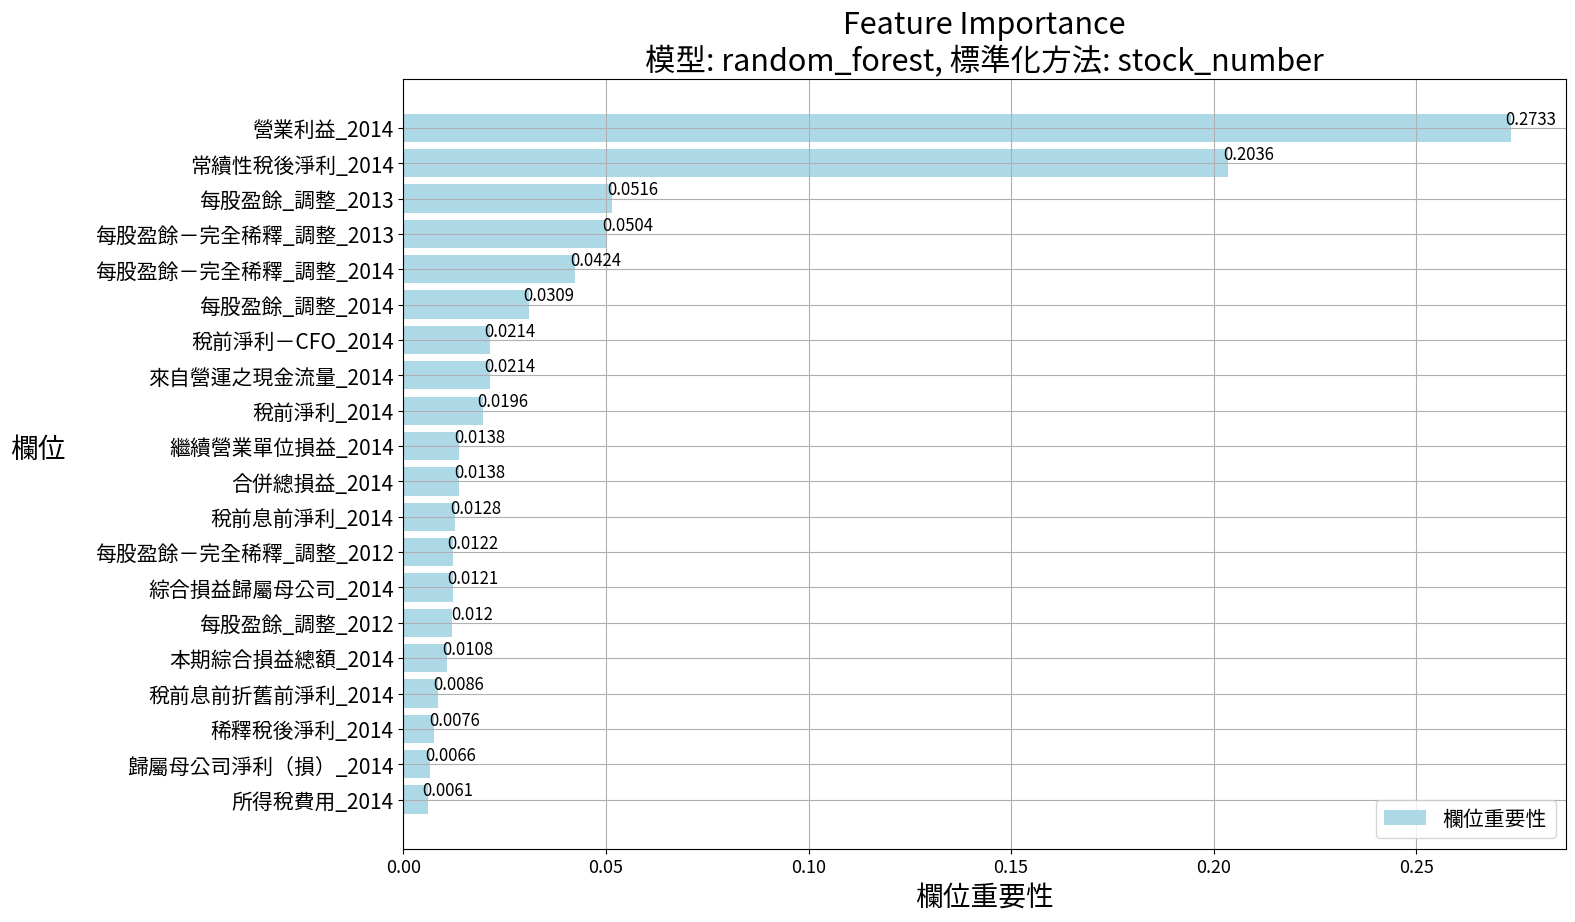

In [62]:
rf_stock_number_feat_importance = plot_feature_importance(result, 'random_forest', 'stock_number')

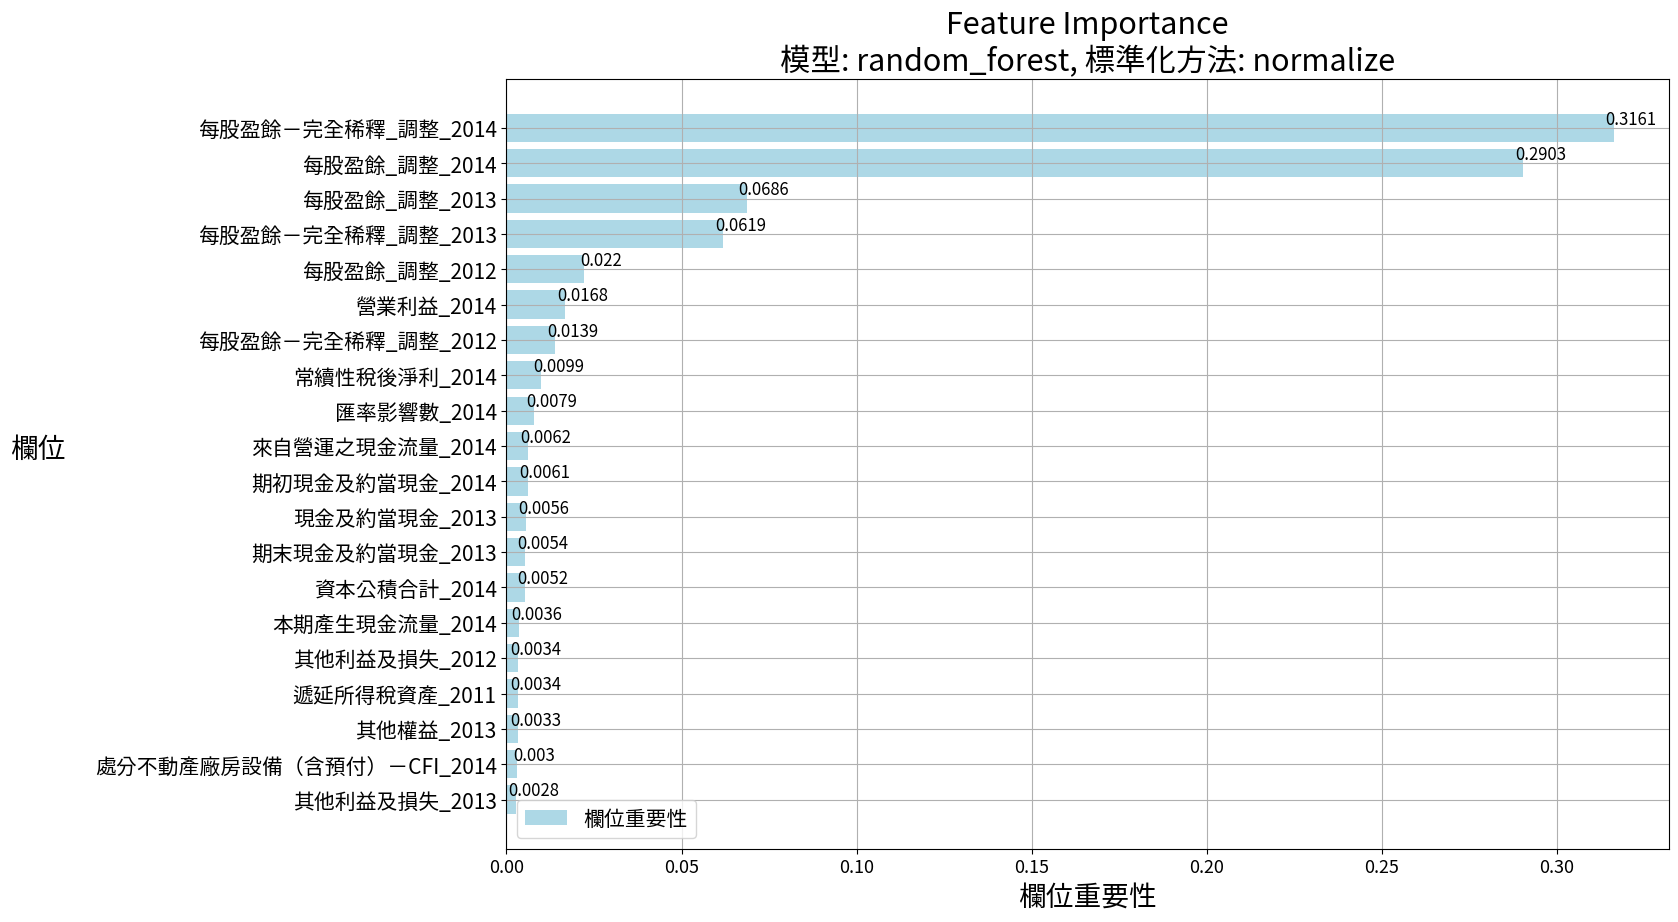

In [63]:
rf_stock_number_feat_importance = plot_feature_importance(result, 'random_forest', 'normalize')

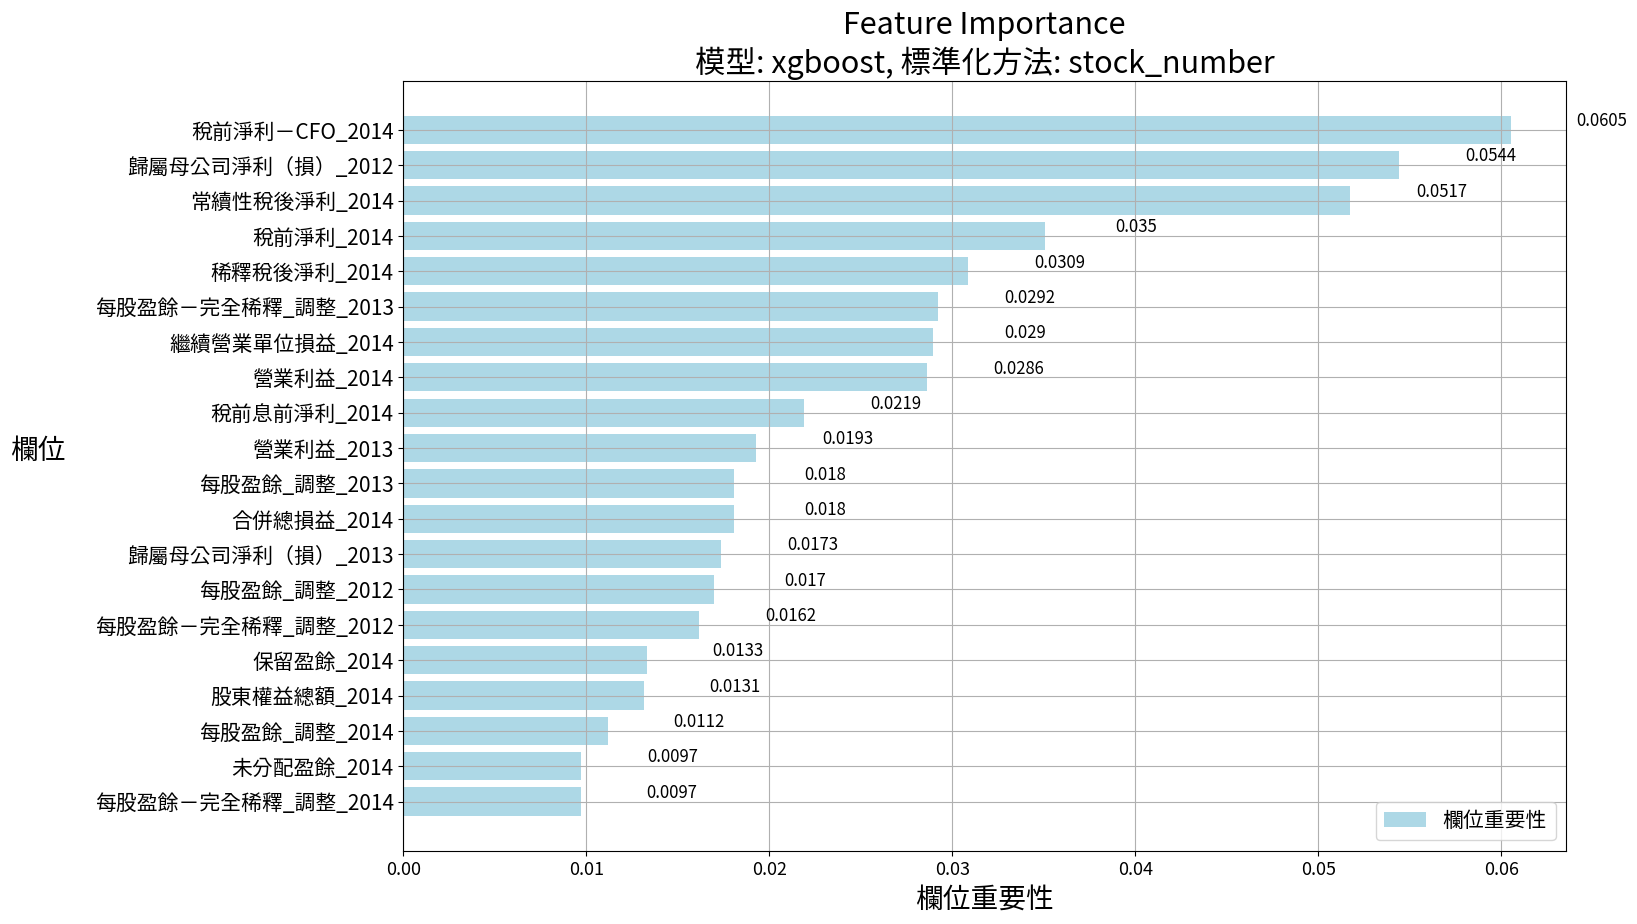

In [64]:
xgb_stock_number_feat_importance = plot_feature_importance(result, 'xgboost', 'stock_number')

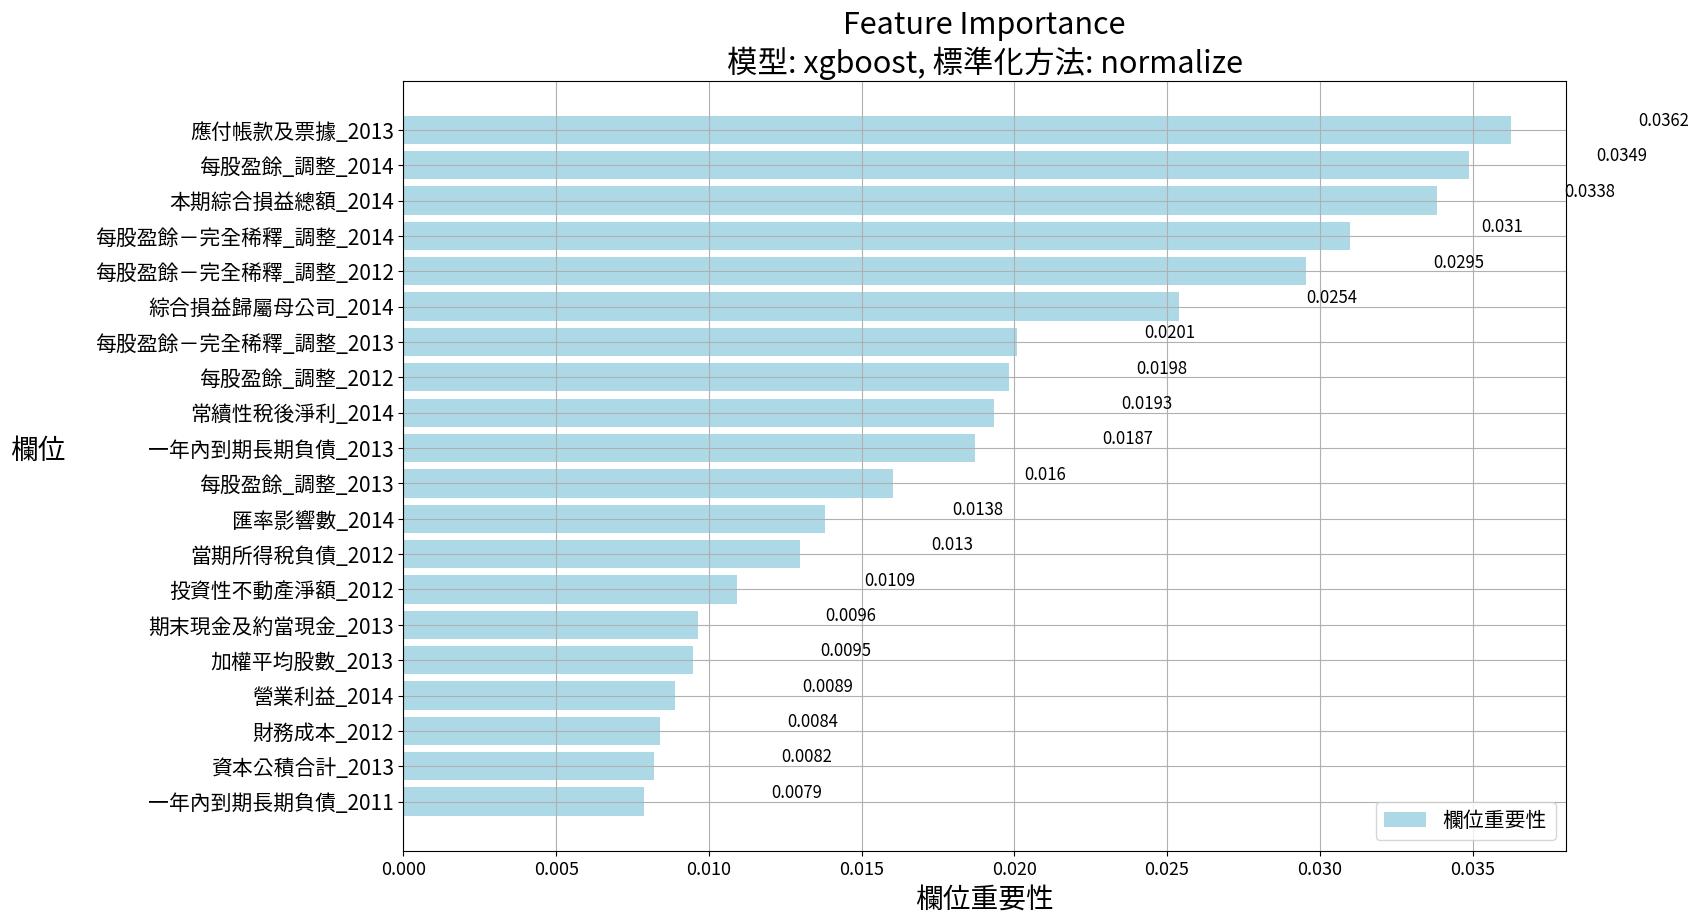

In [65]:
xgb_stock_number_feat_importance = plot_feature_importance(result, 'xgboost', 'normalize')